# библиотеки

In [ ]:
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, concatenate, Reshape, Multiply
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Dropout, RepeatVector, Conv1DTranspose, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import backend as K  # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, Reduction

# from tensorflow.keras.applications import Xception, nasnet, inception_resnet_v2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical      # Для представления в формате one_hot_encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder# Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")  #  фильтр предупреждений # 'ignore'	Никогда не печатать соответствующие предупреждения

gc.collect()

22

In [ ]:
from google.colab import drive                    # Для работы с Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/moduli')
# import PlotFunctions

from PlotFunctions import plt_figure_accuracy

In [ ]:
import PlotFunctions
print(dir(PlotFunctions))            # просмотр содержимого

['K', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'eval_net', 'get_corr', 'ipd', 'librosa', 'load_audio', 'mean_absolute_error', 'mean_squared_error', 'my_f1_score', 'np', 'pd', 'plt', 'plt_figure_accuracy', 'plt_figure_dice_coef', 'plt_figure_f1_score', 'plt_figure_loss', 'plt_figure_mae', 'plt_scatter_pred', 'show_spectre', 'sns']


# Загружаем данные

In [ ]:
train_path = '/content/drive/My Drive/Ярославль/train_dataset_train/'
test_path_csv = '/content/drive/My Drive/Ярославль/test_dataset_test.csv'

os.listdir(train_path)

['sample_solution.csv',
 'Условие_задачи_Чемпионат_Ярославская_область.pdf',
 'train.csv']

In [ ]:
df_sample_solution = pd.read_csv(train_path + 'sample_solution.csv')

In [ ]:
df_sample_solution

,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,0,0,0,0,0
1,54-002-133-01,0,0,0,0,0
2,54-001-007-01,0,0,0,0,0
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,0,0,0,0,0
...,...,...,...,...,...,...
633,54-102-095-01,0,0,0,0,0
634,54-102-235-01,0,0,0,0,0
635,54-502-016-01,0,0,0,0,0
636,54-002-138-01,0,0,0,0,0


In [ ]:
dfTrain = pd.read_csv('/content/drive/My Drive/Ярославль/dfTrain.csv')
dfTest = pd.read_csv('/content/drive/My Drive/Ярославль/dfTest.csv')

In [ ]:
with open('/content/drive/My Drive/Ярославль/dictCodeColums_.pickle', 'rb') as pick:
    dictCodeColums = pickle.load(pick)

In [ ]:
dfTest

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,0,2,1,13,5,1,8,1,0,...,20,8,0,1,1,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
1,54-002-133-01,0,1,1,13,5,3,2,0,1,...,0,32,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
2,54-001-007-01,0,0,1,13,5,3,2,0,1,...,25,28,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
3,54-102-116-01,0,0,1,13,5,2,4,1,0,...,22,14,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
4,54-502-005-02,1,0,1,13,5,1,5,0,1,...,22,14,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,54-102-095-01,0,0,1,13,5,3,2,1,0,...,25,14,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
634,54-102-235-01,0,2,1,13,5,3,2,0,1,...,7,34,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
635,54-502-016-01,0,3,1,13,5,2,10,1,0,...,22,24,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
636,54-002-138-01,0,0,1,13,5,2,7,1,0,...,0,29,0,0,0,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных


In [ ]:
keys_list = list(dictCodeColums.keys())
print(keys_list)

['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Статус Курения', 'Частота пасс кур', 'Алкоголь', 'Время засыпания', 'Время пробуждения', 'Возраст алког', 'Сигарет в день', 'Возраст курения']


In [ ]:
dictCodeColums['Пол']

{0: 'Ж', 1: 'М', 2: nan}

In [ ]:
dictCodeColums['Семья']

{0: 'в браке в настоящее время',
 1: 'в разводе',
 2: 'вдовец / вдова',
 3: 'гражданский брак / проживание с партнером',
 4: 'никогда не был(а) в браке',
 5: 'раздельное проживание (официально не разведены)'}

In [ ]:
gc.collect()

211

# Анализ

In [ ]:
import seaborn as sns

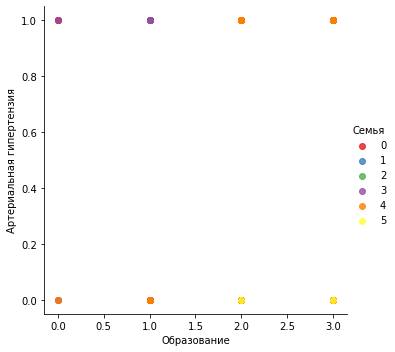

In [ ]:
# Посмотрим на зависимость возраста от ЗП с разбивкой по городам
sns.lmplot(data = dfTrain, x = 'Образование', y='Артериальная гипертензия', hue="Семья", palette="Set1", 
           fit_reg=False)
plt.show()


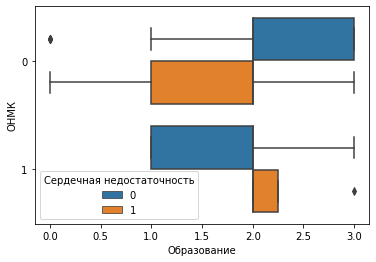

In [ ]:
# Посмотрим на графике данные о ЗП по городам
sns.boxplot(data=dfTrain, x='Образование', y='ОНМК', hue='Сердечная недостаточность', orient='h')
# plt.xlim(0, 350000)
plt.show()

In [ ]:
dfTrain.quantile([0.25, 0.50, 0.75, 0.95, 1.])

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0.25,0.0,0.0,1.0,13.0,5.0,2.0,2.0,0.0,0.0,0.0,...,7.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.50,0.0,0.0,1.0,13.0,5.0,2.0,5.0,1.0,0.0,0.0,...,22.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.75,1.0,2.0,1.0,13.0,5.0,3.0,8.0,1.0,1.0,0.0,...,25.0,29.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.95,1.0,3.0,1.0,13.0,5.0,3.0,10.0,1.0,1.0,0.0,...,26.0,32.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1.00,2.0,5.0,2.0,19.0,5.0,3.0,10.0,1.0,1.0,1.0,...,28.0,37.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


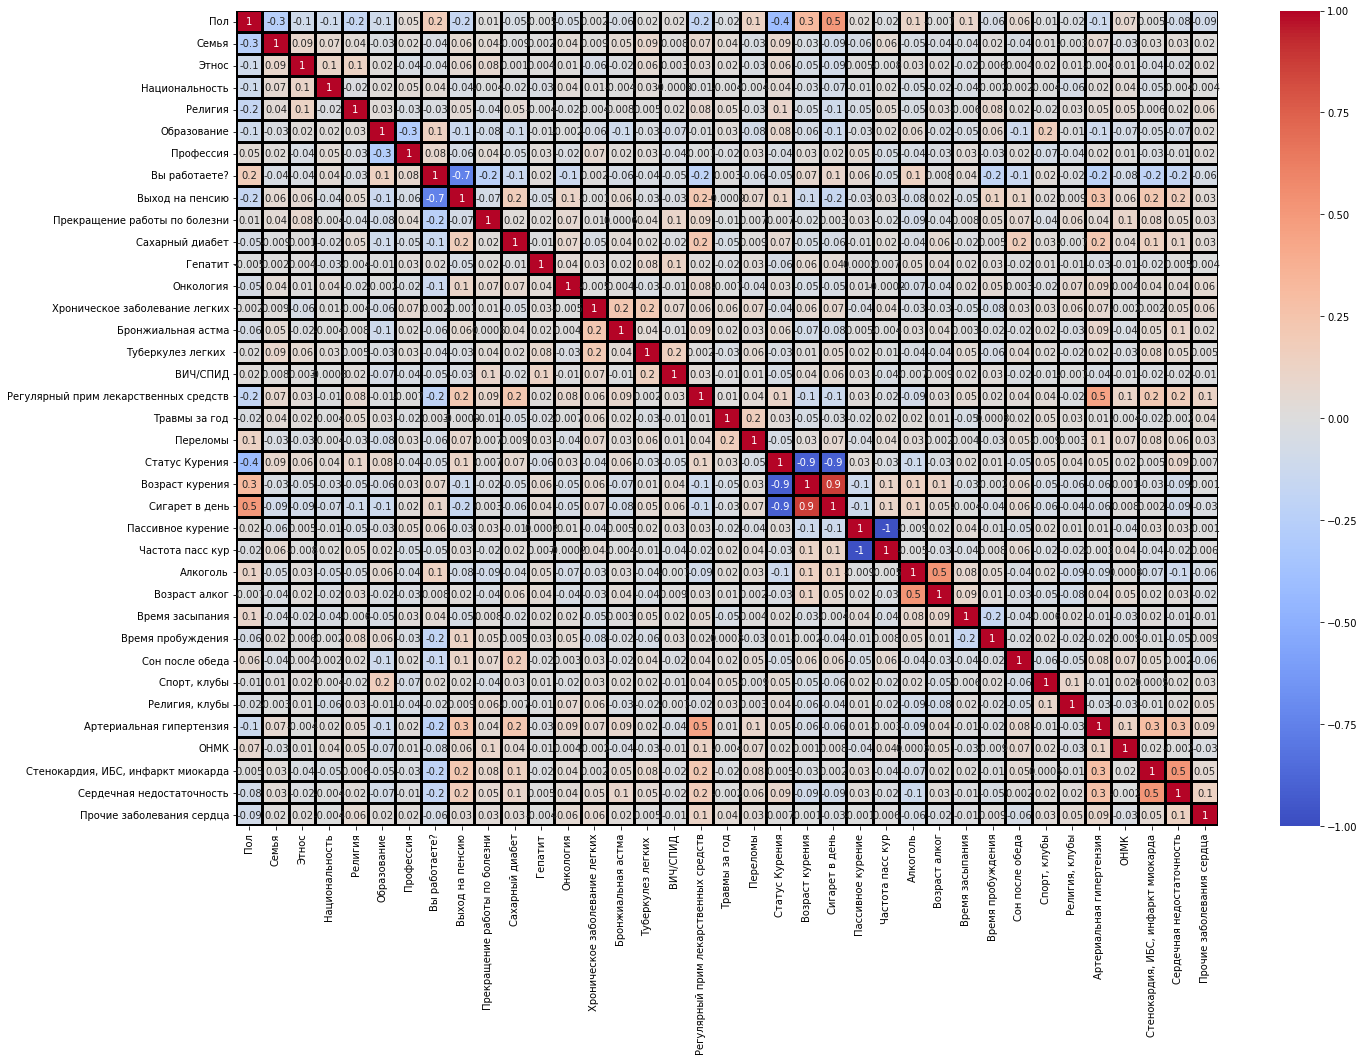

In [ ]:
###   КОРРЕЛЯЦИЯ
# Метод, подсчитывающий попарную корреляцию для элементов.
corr_matrix = dfTrain.corr('spearman') 

# Можно указать в параметрах способ подсчета.
plt.figure(figsize=(22, 15))
sns.heatmap(corr_matrix, cmap= 'coolwarm', vmin=-1, center=0, linewidths=2,
            linecolor='black', annot = True, fmt='.1g') 

plt.show()

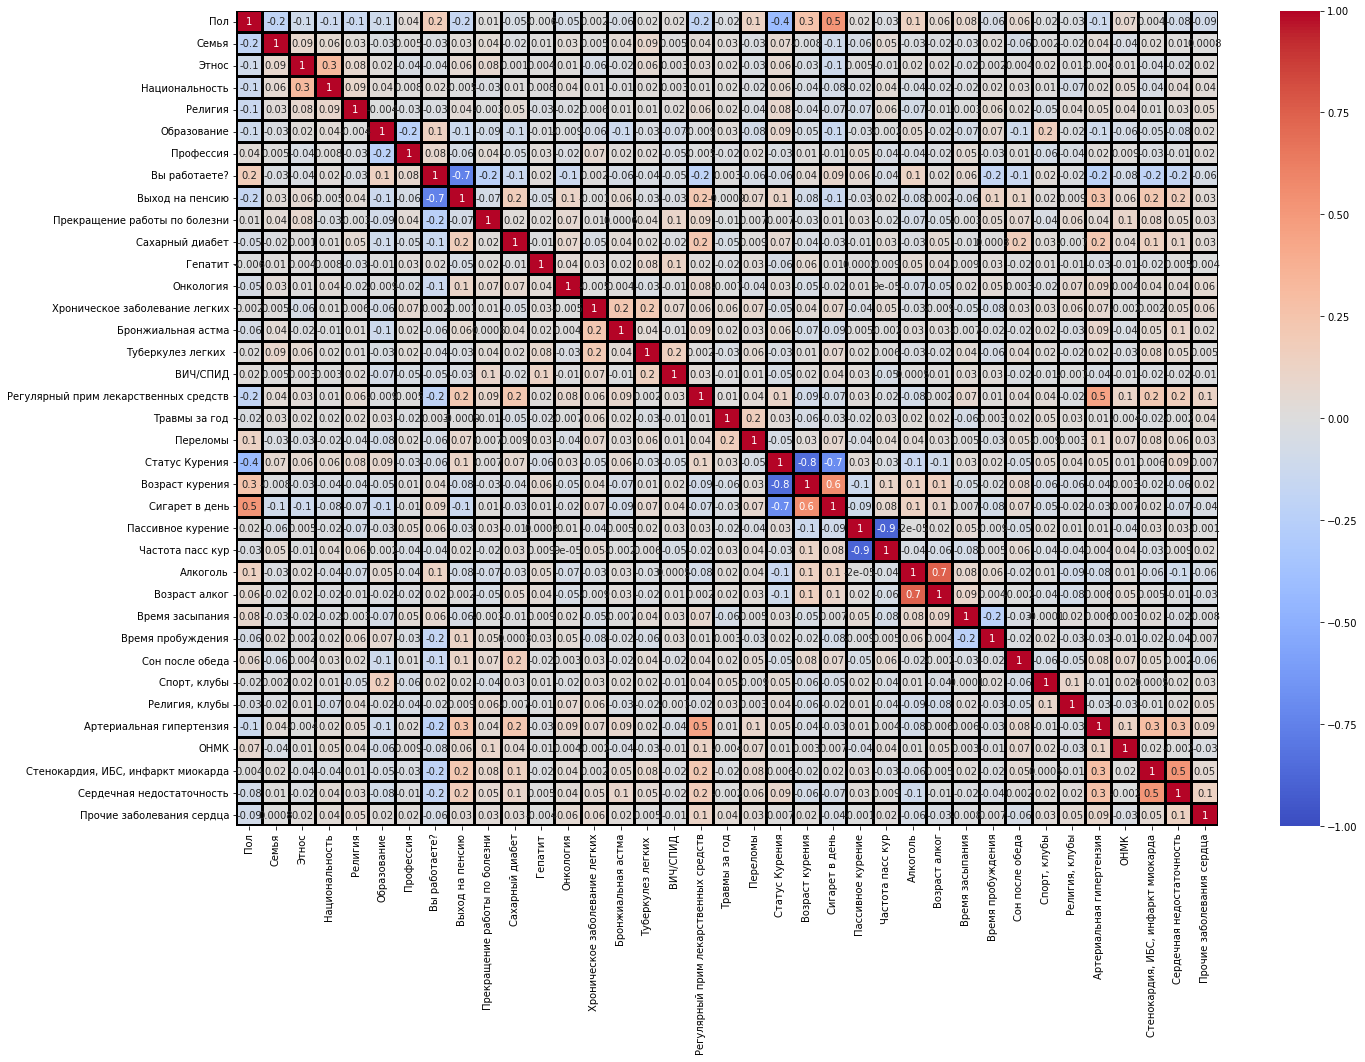

In [ ]:
###   КОРРЕЛЯЦИЯ
# Метод, подсчитывающий попарную корреляцию для элементов.
corr_matrix = dfTrain.corr() 

# Можно указать в параметрах способ подсчета.
plt.figure(figsize=(22, 15))
sns.heatmap(corr_matrix, cmap= 'coolwarm', vmin=-1, center=0, linewidths=2,
            linecolor='black', annot = True, fmt='.1g') 

plt.show()

In [ ]:
print(keys_list)

['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Статус Курения', 'Частота пасс кур', 'Алкоголь', 'Время засыпания', 'Время пробуждения', 'Возраст алког', 'Сигарет в день', 'Возраст курения']


In [ ]:
print(dictCodeColums['Возраст алког'])

{0.18915874140461697: 18.0, -1.7710645152039814: 0.0, 0.08025744937080594: 17.0, -0.35534771876443816: 13.0, -0.028643842663005088: 16.0, 2.0404807059794043: 35.0, -0.4642490107982492: 12.0, 0.406961325472239: 20.0, -0.13754513469681612: 15.0, 0.624763909539861: 22.0, 1.4959742458103493: 30.0, 0.298060033438428: 19.0, 2.58498716614846: 40.0, 0.7336652015736721: 23.0, 0.9514677856412942: 25.0, 3.4561975024189477: 48.0, 1.7137768298779714: 32.0, 0.51586261750605: 21.0, -0.6820515948658713: 10.0, -0.7909528868996822: 9.0, -0.24644642673062714: 14.0, -1.1176567630011154: 6.0, 3.6740000864865703: 50.0, 0.8425664936074831: 24.0, 3.2383949183513256: 46.0, 1.1692703697089162: 27.0, 1.3870729537765383: 29.0, 3.129493626317515: 45.0, 2.1493819980132156: 36.0, 2.2582832900470264: 37.0, 1.0603690776751051: 26.0, 1.8226781219117825: 33.0, 5.089716882926114: 63.0, 1.2781716617427272: 28.0, 2.9116910422498927: 43.0, 3.0205923342837036: 44.0, 4.76301300682468: 60.0}


# Формируем XY / урезаем данные

In [ ]:
columns = list(dfTrain.columns)
print(columns)


['ID', 'Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 'Туберкулез легких ', 'ВИЧ/СПИД', 'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Пассивное курение', 'Частота пасс кур', 'Алкоголь', 'Возраст алког', 'Время засыпания', 'Время пробуждения', 'Сон после обеда', 'Спорт, клубы', 'Религия, клубы', 'Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


In [ ]:
print(len(dfTrain.columns))
dfTrain.columns

38


Index(['ID', 'Пол', 'Семья', 'Этнос', 'Национальность', 'Религия',
       'Образование', 'Профессия', 'Вы работаете?', 'Выход на пенсию',
       'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит',
       'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма',
       'Туберкулез легких ', 'ВИЧ/СПИД',
       'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы',
       'Статус Курения', 'Возраст курения', 'Сигарет в день',
       'Пассивное курение', 'Частота пасс кур', 'Алкоголь', 'Возраст алког',
       'Время засыпания', 'Время пробуждения', 'Сон после обеда',
       'Спорт, клубы', 'Религия, клубы', 'Артериальная гипертензия', 'ОНМК',
       'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
       'Прочие заболевания сердца'],
      dtype='object')

In [ ]:
dfTrain.columns[-5:]

Index(['Артериальная гипертензия', 'ОНМК',
       'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
       'Прочие заболевания сердца'],
      dtype='object')

In [ ]:
columnsX = ['Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Бронжиальная астма', 'Регулярный прим лекарственных средств', 'Переломы', 'Алкоголь', 'Возраст алког']
len(columnsX)

9

In [ ]:
dfTrain[columnsX]

,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Бронжиальная астма,Регулярный прим лекарственных средств,Переломы,Алкоголь,Возраст алког
0,1,0,0,0,0,0,0,2,0.189159
1,0,0,0,1,0,1,1,0,-1.771065
2,0,0,0,0,0,1,0,2,0.080257
3,1,0,0,0,0,1,0,2,-0.355348
4,0,0,1,1,0,1,1,2,-0.028644
...,...,...,...,...,...,...,...,...,...
950,1,0,0,0,0,0,1,2,0.189159
951,1,0,0,0,0,1,0,1,1.060369
952,0,1,0,0,0,1,0,2,0.406961
953,1,0,0,0,0,1,0,2,0.515863


In [ ]:
xAll = dfTrain[columnsX].values
print('Количество столбцов', len(xAll[0]))
xAll

Количество столбцов 9


array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         2.        ,  0.18915874],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -1.77106452],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.        ,  0.08025745],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         2.        ,  0.40696133],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         2.        ,  0.51586262],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         2.        ,  0.08025745]])

In [ ]:
columnsY = columns[-5:]
print(columnsY)

['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


In [ ]:
yAll = dfTrain.iloc[:, -5:].values
print('Количество столбцов', len(yAll[0]))
yAll

Количество столбцов 5


array([[0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
# Разбиение наборов на общую и тестовую выборки
x_all, x_test, y_all, y_test = train_test_split(xAll, 
                                                yAll, 
                                                test_size=0.1, 
                                                shuffle=True, 
                                                random_state = 6)

# Разбиение общей выборки на обучающую и проверочную 
x_train, x_val, y_train, y_val  = train_test_split(x_all, y_all,
                                                test_size=0.1, 
                                                shuffle=True, 
                                                random_state = 6)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(773, 9)
(773, 5)
(96, 9)
(96, 5)
(86, 9)
(86, 5)


In [ ]:
XTest = dfTest[columnsX].values
print('Количество столбцов', len(XTest[0]))
XTest

Количество столбцов 9


array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         2.        ,  0.7336652 ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         2.        ,  0.62476391],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         2.        ,  0.18915874],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.95146779],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.77106452],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         2.        ,  0.08025745]])

# сервисные функции

In [ ]:
from sklearn.metrics import recall_score
# recall_score(average = "macro") #- это 0.5*recall класса 0 + 0.5*recall класса 1

In [ ]:
ServiceFaile = '''
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder# Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")  #  фильтр предупреждений # 'ignore'	Никогда не печатать соответствующие предупреждения

from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall

metrics = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    Precision(name="precision")
]

metricsRecall = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall")
]

def predictSampling(model, Sampling):
  print('Размерность выборки ', Sampling.shape)
  pred = model.predict(Sampling)

  for i in range(pred.shape[0]):
    pred[i] = [int(1) if pred[i][j] >= 0.5 else int(0) for j in range(len(pred[i]))]

  return pred

'''

# Сохраняем код выше в файл
with open('Service.py', 'w') as file:
    file.write(ServiceFaile)


In [ ]:
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall

metrics = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    Precision(name="precision")
]

metricsRecall = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall")
]

In [ ]:
# Функция нужна для точности
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
def pltFigureValLoss(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['loss'], 
         label='Ошибка на обучающем наборе')
  plt.plot(history_.history['val_loss'], 
         label=f'Ошибка на проверочном наборе, {round(history_.history["val_loss"][-1], 5)}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid()
  plt.show()

def pltFigureValRecall(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['recall'], 
         label='recall на обучающем наборе')
  plt.plot(history_.history['val_recall'], 
         label=f'recall на проверочном наборе, {round(history_.history["val_recall"][-1], 5)}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Recall')
  plt.legend()
  plt.grid()
  plt.show()

def pltFigureValFN(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['fn'], 
         label='fn на обучающем наборе')
  plt.plot(history_.history['val_fn'], 
         label=f'fn на проверочном наборе, {round(history_.history["val_fn"][-1], 5)}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('FN')
  plt.legend()
  plt.grid()
  plt.show()


def pltFigureLoss(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['loss'], 
         label='Ошибка на обучающем наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid()
  plt.show()

def pltFigureRecall(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['recall'], 
         label='recall на обучающем наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Recall')
  plt.legend()
  plt.grid()
  plt.show()

def pltFigureFN(history_):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history['fn'], 
         label='fn на обучающем наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('FN')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

patch = '/content/drive/My Drive/Ярославль/'
model_checkpoint = ModelCheckpoint(filepath=os.path.join(patch, 'model_weights.h5'), 
                                   monitor='val_recall', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='max')   # mode='auto'

# patchMod = '/content/drive/My Drive/Ярославль/model_weightsUnet.h5'
# callbacks=[model_checkpoint]

In [ ]:
def evalModel(model):
  print('x_test.shape ', x_test.shape)
  print('y_test.shape ', y_test.shape, '\n')
  model.evaluate(x_test,y_test)
  
  pred = model.predict(x_test)
  print('pred.shape ',pred.shape)

  for i in range(pred.shape[0]):
      pred[i] = [1 if pred[i][j] >= 0.5 else 0 for j in range(len(pred[i]))]

  perc = 0
  for j in range(pred.shape[1]):
    synced = 0
    for i in range(pred.shape[0]):
        synced += (1 if pred[i][j] == y_test[i][j] else 0)
    
    perc += round(synced/pred.shape[0] *100, 2)
    print('по столбцу ', j, " совпало " , synced, ' что составляет ', round(synced/pred.shape[0] *100, 2) , ' %')
  print('Итоговый процент  ', perc/pred.shape[1], ' % \n')



  for i in range(pred.shape[0]):
     print('Пример: ', i, ' Сеть определила: ', pred[i], ' --> верный ответ: ', y_test[i])

In [ ]:
def compilingSample(model):

    print('x_test.shape ', x_test.shape)
    print('y_test.shape ', y_test.shape, '\n')
    model.evaluate(x_test,y_test)

    def finalPredict(model):
        print('\nXTest.shape ', XTest.shape)
        pred = model.predict(XTest)

        for i in range(pred.shape[0]):
            pred[i] = [int(1) if pred[i][j] >= 0.5 else int(0) for j in range(len(pred[i]))]

        return pred
    
    # ПРЕДИКТ МОДЕЛИ 
    predict = finalPredict(model) 
    print('predict готов -->' , 'pred.shape ', predict.shape)
    print(predict[:5], '\n')
    
    # МЕНЯЕМ dfTest
    colum = list(df_sample_solution.columns)[1:] 
    for i, col in enumerate(colum):
        dfTest[col] = predict[:, i]
        dfTest[col] = dfTest[col].astype('int8')

    # СОЗДАЕМ НОВЫЙ DataFrame для отчета 
    colum = list(df_sample_solution.columns)
    df_sample = dfTest[colum]
    
    return df_sample


In [ ]:
def confusionMatrix(model):
    class_list = ['Артериальная', 'ОНМК', 'Инфаркт', 'Сердечная недост', 'Прочие']
    pred = model.predict(x_test)

    for i in range(pred.shape[0]):
        pred[i] = [1 if pred[i][j] >= 0.5 else 0 for j in range(len(pred[i]))]

    print('y_test.shape -->', y_test.shape)
    print('pred.shape -->', pred.shape)

    
    fig, ax = plt.subplots(1, len(class_list), sharex= False, sharey= False, figsize =(22,5))
    for i in range(len(class_list)):
        # Для OHE pred.argmax(axis=1)
        cm = confusion_matrix(y_test[:,i], pred[:,i], normalize = "true") 

        ax[i].set_title(f'{class_list[i]}')
        disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                      display_labels = ['нет', 'есть'])
                                      # display_labels = ['есть', 'нет'])
        disp.plot(ax=ax[i])
        plt.xticks(rotation = 30)

    plt.show()


# class_weight

In [ ]:
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
#                                                  classes = data.individual_id.unique(),  # из df столбец "individual_id"
#                                                  y = data.individual_id.values)          # из df столбец "individual_id"
# class_weights

In [ ]:
x_train

array([[1.        , 0.        , 0.        , ..., 0.        , 2.        ,
        0.18915874],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.40696133],
       [1.        , 0.        , 0.        , ..., 0.        , 2.        ,
        0.18915874],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 2.        ,
        0.18915874],
       [1.        , 0.        , 0.        , ..., 0.        , 2.        ,
        0.40696133],
       [0.        , 0.        , 0.        , ..., 0.        , 2.        ,
        0.08025745]])

In [ ]:
x_train[:, 0][:10]

array([1., 1., 1., 0., 0., 0., 1., 1., 0., 0.])

In [ ]:
x_train.shape

(773, 9)

Функция bincount() возвращает количество вхождений значений в массиве. Данная функция выполняет подсчет только целых положительных чисел. Если на вход подан массив с числами типа float или complex, то будет вызвано исключение TypeError.

In [ ]:
counts = np.bincount([0., 1., 1., 1., 2.,2., 3., 4., 4., 4., 5., 5., 6.])
counts

array([1, 3, 2, 1, 3, 2, 1])

In [ ]:
# https://keras.io/examples/structured_data/imbalanced_classification/

counts = np.bincount(list(x_train[:, 0]))
print(
    "Количество положительных образцов в обучающих данных: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(x_train)
    )
)

print(counts)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Количество положительных образцов в обучающих данных: 402 (52.01% of total)
[371 402]


In [ ]:
for i in range(x_train.shape[-1]-1):
  counts = np.bincount(list(x_train[:, i]))
  print(counts)

[371 402]
[507 266]
[738  35]
[701  72]
[739  34]
[275 498]
[489 284]
[132 127 514]


In [ ]:
dfTrain['Возраст алког'].nunique()

36

In [ ]:
print(columnsY)

['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


In [ ]:
columnsY[0]

'Артериальная гипертензия'

In [ ]:
dfTrain[columnsY[0]].unique()

array([0, 1])

In [ ]:
dfTrain[columnsY[3]].values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
np.unique(dfTrain[columnsY[0]])

array([0, 1])

In [ ]:
from sklearn.utils import class_weight
class_weights0 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(dfTrain[columnsY[0]]),  # из df столбец 'Артериальная гипертензия'
                                                 y = dfTrain[columnsY[0]].values)          # из df столбец 'Артериальная гипертензия'
class_weights0

array([0.93811395, 1.0706278 ])

In [ ]:
dict(enumerate(class_weights0))

{0: 0.9381139489194499, 1: 1.0706278026905829}

In [ ]:
class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = dfTrain[columnsY[1]].unique(),  
                                                 y = dfTrain[columnsY[1]].values)          
class_weights1

array([ 0.52242888, 11.64634146])

In [ ]:
class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = dfTrain[columnsY[2]].unique(), 
                                                 y = dfTrain[columnsY[2]].values)          
class_weights2

array([0.56980907, 4.08119658])

In [ ]:
class_weights3 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = dfTrain[columnsY[3]].unique(), 
                                                 y = dfTrain[columnsY[3]].values)          
class_weights3

array([0.55587893, 4.97395833])

In [ ]:
class_weights4 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = dfTrain[columnsY[4]].unique(), 
                                                 y = dfTrain[columnsY[4]].values)          
class_weights4

array([0.54948216, 5.55232558])

In [ ]:
class_weight = {0: class_weights0, 1: class_weights1, 2:class_weights2, 3:class_weights3, 4:class_weights4}

In [ ]:
class_ids = list(sorted(class_weight.keys()))
class_ids

[0, 1, 2, 3, 4]

In [ ]:
# https://docs-python.ru/standart-library/modul-collections-python/klass-counter-modulja-collections/

# >>> from collections import Counter
# >>> cnt = Counter(['red', 'blue', 'red', 'green', 'blue', 'blue'])
# >>> dict(cnt)
# # {'blue': 3, 'red': 2, 'green': 1}

# Объект Counter, атрибуты и методы:
# Counter.elements() возвращает итератор по элементам.
# Counter.most_common() список наиболее распространенных элементов.
# Counter.subtract() вычитает элементы счетчика и итерируемой последовательности.
# Counter.total() вычисляет сумму значений счетчика.
# Counter.update() складывает элементы счетчика и итерируемой последовательности.

# def get_class_weights(y):
#     counter = Counter(y)
#     majority = max(counter.values())
#     return  {cls: float(majority/count) for cls, count in counter.items()}

In [ ]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory

# from collections import Counter
# train_datagen = ImageDataGenerator()
# train_generator = train_datagen.flow_from_directory(...)

# counter = Counter(train_generator.classes)                          
# max_val = float(max(counter.values()))       
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

# model.fit_generator(...,
#                     class_weight=class_weights)

In [ ]:
columnsY = columns[-5:]
print(columnsY)

['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


In [ ]:
dfTrain[columnsY[3]].unique()

array([0, 1])

In [ ]:
len(dfTrain[columnsY[0]])

955

In [ ]:
from collections import Counter
maxlen = len(dfTrain[columnsY[0]])
print('Всего примеров До разбивки на выборки= ', len(dfTrain[columnsY[0]]))
counter0 = Counter(dfTrain[columnsY[0]].values)
print(counter0)
counter1 = Counter(dfTrain[columnsY[1]].values)
print(counter1)
counter2 = Counter(dfTrain[columnsY[2]].values)
print(counter2)
counter3 = Counter(dfTrain[columnsY[3]].values)
print(counter3)
counter4 = Counter(dfTrain[columnsY[4]].values)
print(counter4)

Всего примеров До разбивки на выборки=  955
Counter({0: 509, 1: 446})
Counter({0: 914, 1: 41})
Counter({0: 838, 1: 117})
Counter({0: 859, 1: 96})
Counter({0: 869, 1: 86})


In [ ]:
counter0[1]

446

In [ ]:
print(maxlen/counter0[1]/5)
print(maxlen/counter1[1]/5)

0.42825112107623314
4.658536585365853


Допустим, у вас есть 500 образцов класса 0 и 1500 образцов класса 1, чем вы кормите в class_weight = {0:3 , 1:1}. Это дает классу 0 в три раза больше веса класса 1.

In [ ]:
class_weight = {0: 1, 1: 2, 2: 1.5, 3: 1.7, 4: 1.7}

In [ ]:
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}       

classes =  [counter0[1], counter1[1], counter2[1], counter3[1], counter4[1]]
classes

[446, 41, 117, 96, 86]

In [ ]:
class_weights = {class_id : maxlen/didg for class_id, didg in enumerate(classes)} 
class_weights 

{0: 2.1412556053811658,
 1: 23.29268292682927,
 2: 8.162393162393162,
 3: 9.947916666666666,
 4: 11.104651162790697}

In [ ]:
2.14**0.5

1.4628738838327795

# Матрица ошибок

Возвращает
c  форма (n_classes, n_classes)
Матрица путаницы, запись i-й строки и j-го столбца которой указывает на количество выборок с истинной меткой, являющейся i-м классом, и прогнозируемой меткой, являющейся j-м классом.



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
pred = model.predict(x_test)

print(y_test.shape)
print(pred.shape)

(96, 5)
(96, 5)


In [ ]:
pred[0]

array([0.57852674, 0.27347976, 0.3507476 , 0.32417357, 0.33304328],
      dtype=float32)

In [ ]:
y_test[0]

array([0, 0, 0, 0, 0])

In [ ]:
pred[:,0]

In [ ]:
class_list = ['Артериальная гипертензия', 'ОНМК', 'Инфаркт миокарда', 'Сердечная недостаточность', 'Прочие']

In [ ]:
# Для OHE pred.argmax(axis=1)
cm = confusion_matrix(y_test[:,0], pred[:,0], normalize = "true") 

ValueError: ignored

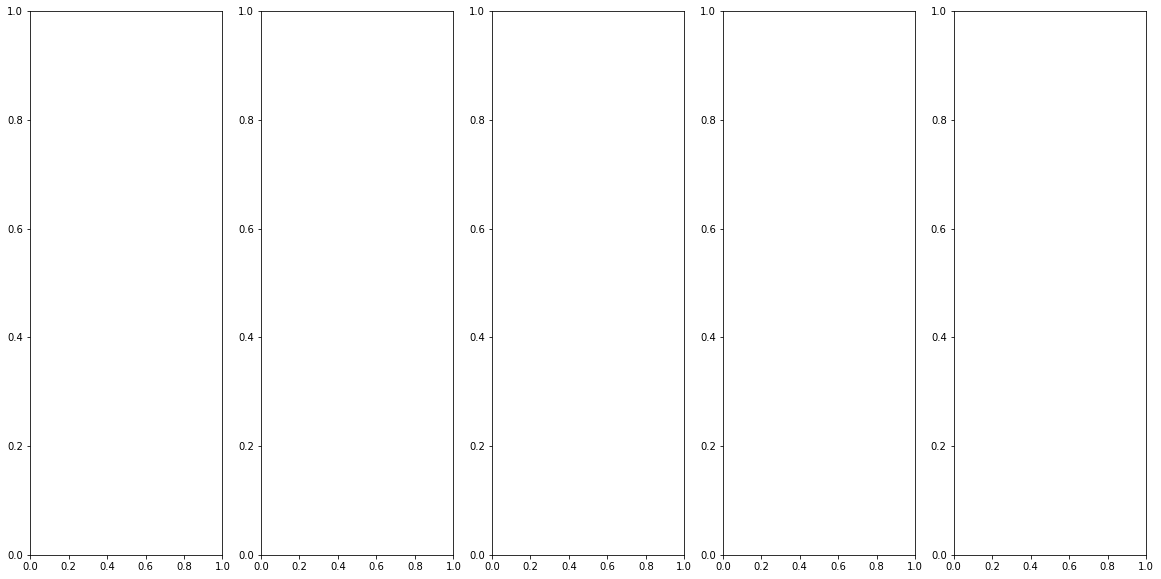

In [ ]:


class_list = ['Артериальная', 'ОНМК', 'Инфаркт', 'Сердечная недост', 'Прочие']
fig, ax = plt.subplots(1, len(class_list), sharex= False, sharey= False, figsize =(20,10))
for i in range(len(class_list)):
  # Для OHE pred.argmax(axis=1)
  cm = confusion_matrix(y_test[:,i], pred[:,i], normalize = "true") 

  ax[i].set_title(f'{class_list[i]}')
  disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                display_labels = ['есть', 'нет'])
  disp.plot(ax=ax[i])
  plt.xticks(rotation = 30)

plt.show()

In [ ]:
def confusionMatrix(model):
    class_list = ['Артериальная', 'ОНМК', 'Инфаркт', 'Сердечная недост', 'Прочие']
    pred = model.predict(x_test)

    for i in range(pred.shape[0]):
        pred[i] = [1 if pred[i][j] >= 0.5 else 0 for j in range(len(pred[i]))]

    print('y_test.shape -->', y_test.shape)
    print('y_test.shape -->', pred.shape)
    
    fig, ax = plt.subplots(1, len(class_list), sharex= False, sharey= False, figsize =(22,5))
    for i in range(len(class_list)):
        # Для OHE pred.argmax(axis=1)
        cm = confusion_matrix(y_test[:,i], pred[:,i], normalize = "true") 

        ax[i].set_title(f'{class_list[i]}')
        disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                      display_labels = ['нет', 'есть'])
                                      # display_labels = ['есть', 'нет'])
        disp.plot(ax=ax[i])
        plt.xticks(rotation = 30)

    plt.show()



y_test.shape --> (96, 5)
y_test.shape --> (96, 5)


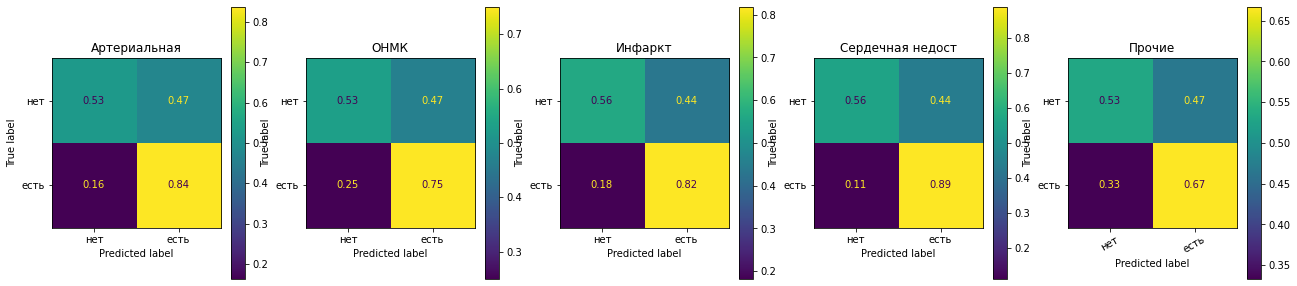

In [ ]:
confusionMatrix(model)

y_test.shape --> (96, 5)
y_test.shape --> (96, 5)


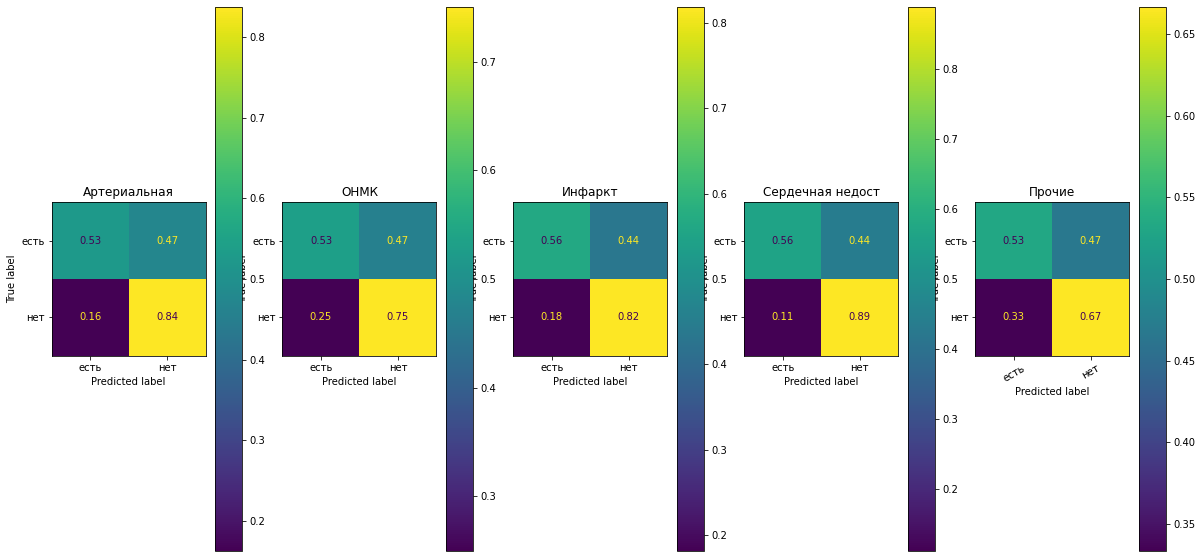

In [ ]:
confusionMatrix(model)

# Conv1d (recall 80.82) > Score = 0.699778  
# Итоговый!
* обучение на всей выборке без разбивки
* урезан: 9 столбцов, + class_weights 

{0: 2.1412556053811658,
 1: 23.29268292682927,
 2: 8.162393162393162,
 3: 9.947916666666666,
 4: 11.104651162790697}




In [ ]:
class_weight = {0: 2.1412556053811658,
 1: 23.29268292682927,
 2: 8.162393162393162,
 3: 9.947916666666666,
 4: 11.104651162790697}

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

patch = '/content/drive/My Drive/Ярославль/'
model_checkpoint = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsLoss.h5'), 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

model_checkpoint_recall = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsRecall.h5'), 
                                   monitor='recall', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='max')   # mode='auto'

# patchMod = '/content/drive/My Drive/Ярославль/model_weightsUnet.h5'
# callbacks=[model_checkpoint]

gc.collect()

172

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(xAll.shape)
print(yAll.shape)

(773, 9)
(773, 5)
(955, 9)
(955, 5)


In [ ]:
MODELFaile = '''
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, concatenate, Reshape, Multiply
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Dropout, RepeatVector, Conv1DTranspose, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import backend as K  # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, Reduction


from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall

metrics = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    Precision(name="precision")
]

metricsRecall = [
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    Recall(name="recall")
]



def create_Conv1_D(numN=32, k = 1, num_classes = 5, input_shape= (9,), drop = 0.4):
    x_input = Input(input_shape) 
    # x = Reshape((32, 1))(x_input)
    
    x = Dense(numN)(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop)(x)

    x = Dense(numN*2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((numN*2, 1))(x)

    # Блок 1
    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    x = Activation('relu')(x)

    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    x = Activation('relu')(x)

    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)  
    block_1_out = Activation('relu')(x) 

    # Блок 2
    # x = MaxPooling1D()(block_1_out)
    x = AveragePooling1D()(block_1_out)

    x = Conv1D(numN * 2 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(numN * 2 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    # x = MaxPooling1D()(block_2_out)
    x = AveragePooling1D()(block_2_out)

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)                     

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x = Dropout(drop)(x)

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    # x = MaxPooling1D()(block_3_out)
    x = AveragePooling1D()(block_3_out)

    x = Conv1D(numN * 8 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    
    x = Conv1D(numN * 8  * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    
    
    f1 = Flatten()(block_1_out)
    f2 = Flatten()(block_2_out)
    f3 = Flatten()(block_3_out)
    f4 = Flatten()(block_4_out)

    x = concatenate([f1, f2, f3, f4])
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(x_input, out) 
    model.compile(optimizer=Adam(0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])
  
    return model

'''

# Сохраняем код выше в файл
with open('MODEL.py', 'w') as file:
    file.write(MODELFaile)

In [ ]:
import ServiceFeatures
import MODEL

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 32)           320         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 32)          128         ['dense_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 32)           0           ['batch_normalization_39[0]

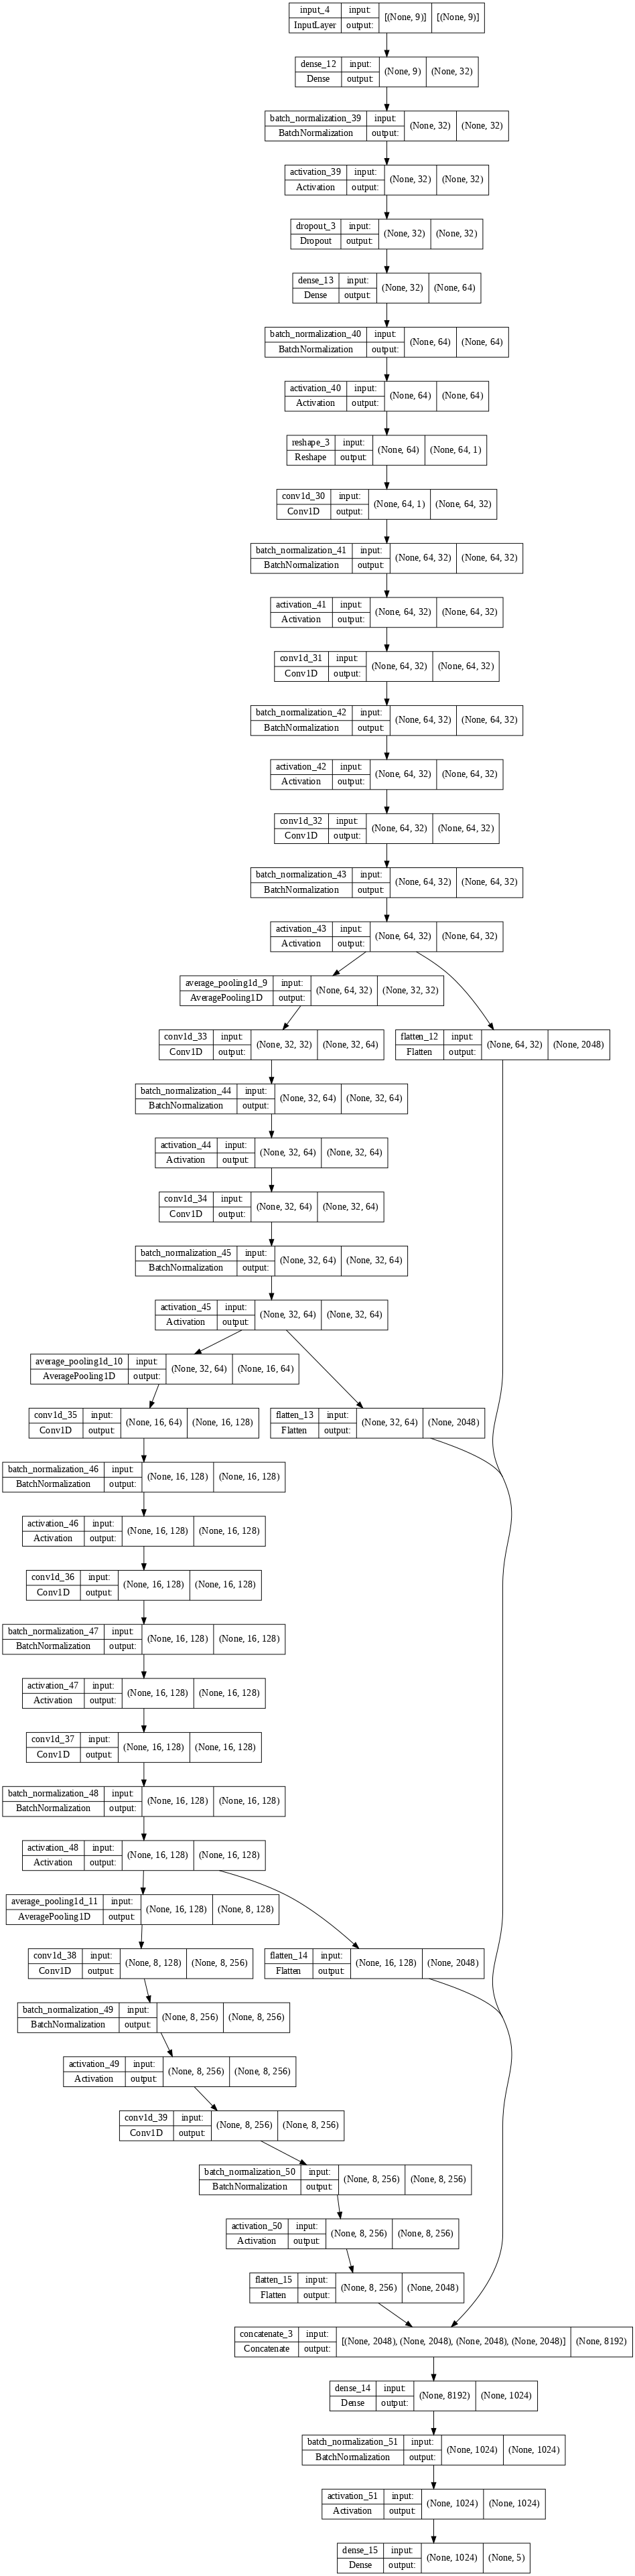

In [ ]:
model = MODEL.create_Conv1_D()
model.summary()
print()
plot_model(model, dpi=70, show_shapes=True )

In [ ]:
history2 = model.fit(xAll, yAll,
                    epochs=50, 
                    verbose=1,
                    batch_size = 32,
                    # validation_data=(x_val, y_val),
                    class_weight=class_weight,
                    callbacks=[model_checkpoint, model_checkpoint_recall])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 5.8590 - accuracy: 0.5623 - fn: 509.0000 - tp: 835.0000 - recall: 0.6213 - fp: 2169.0000 - tn: 4622.0000 - precision: 0.2780
Epoch 1: loss improved from inf to 5.85901, saving model to /content/drive/My Drive/Ярославль/model_weightsLoss.h5

Epoch 1: recall improved from -inf to 0.62128, saving model to /content/drive/My Drive/Ярославль/model_weightsRecall.h5
30/30 [==============================] - 10s 170ms/step - loss: 5.8590 - accuracy: 0.5623 - fn: 509.0000 - tp: 835.0000 - recall: 0.6213 - fp: 2169.0000 - tn: 4622.0000 - precision: 0.2780
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 4.2851 - accuracy: 0.5382 - fn: 323.0000 - tp: 463.0000 - recall: 0.5891 - fp: 1262.0000 - tn: 2727.0000 - precision: 0.2684
Epoch 2: loss improved from 5.85901 to 4.28513, saving model to /content/drive/My Drive/Ярославль/model_weightsLoss.h5

Epoch 2: recall did not improve from 0.62128
30/30 [=================

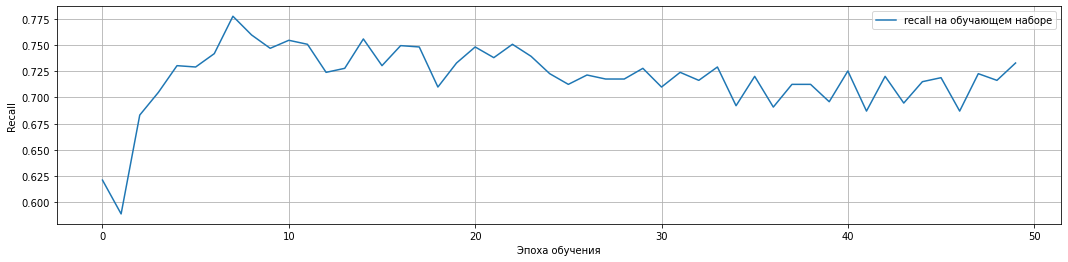

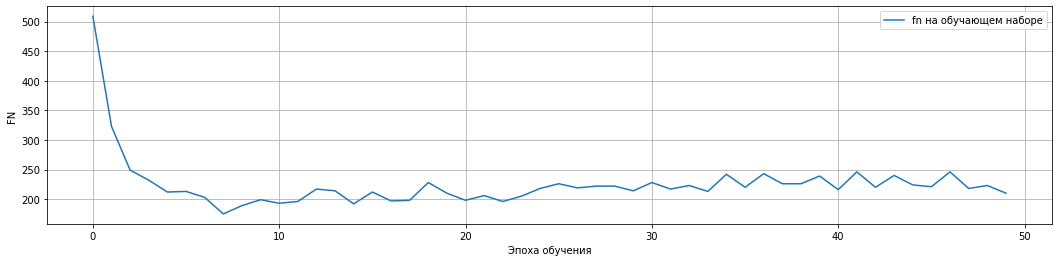

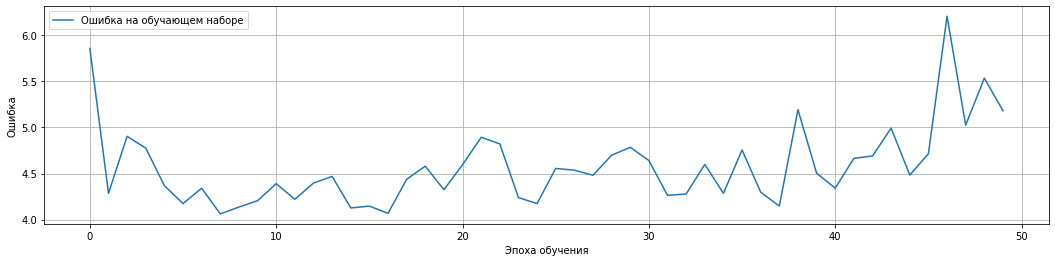

In [ ]:
pltFigureRecall(history2)
pltFigureFN(history2)
pltFigureLoss(history2)


In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsLoss.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 49ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950


In [ ]:
score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 29ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 29ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950
pred.shape  (96, 5)
по столбцу  0  совпало  65  что составляет  67.71  %
по столбцу  1  совпало  64  что составляет  66.67  %
по столбцу  2  совпало  67  что составляет  69.79  %
по столбцу  3  совпало  68  что составляет  70.83  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   67.708  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 0. 0. 0. 1.]  --> верный отв

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsRecall.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 50ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 30ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950
pred.shape  (96, 5)
по столбцу  0  совпало  65  что составляет  67.71  %
по столбцу  1  совпало  64  что составляет  66.67  %
по столбцу  2  совпало  67  что составляет  69.79  %
по столбцу  3  совпало  68  что составляет  70.83  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   67.708  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 0. 0. 0. 1.]  --> верный отв

In [ ]:
# model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d.h5')

model.compile(optimizer=Adam(0.0008), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])

history2 = model.fit(xAll, yAll,
                    epochs=80, 
                    verbose=1,
                    batch_size = 32,
                    # validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint, model_checkpoint_recall],
                    initial_epoch = 50)

Epoch 51/80
30/30 [==============================] - ETA: 0s - loss: 1.2810 - accuracy: 0.8838 - fn: 198.0000 - tp: 661.0000 - recall: 0.7695 - fp: 1750.0000 - tn: 2646.0000 - precision: 0.2742
Epoch 51: loss improved from 4.06198 to 1.28103, saving model to /content/drive/My Drive/Ярославль/model_weightsLoss.h5

Epoch 51: recall did not improve from 0.77735
30/30 [==============================] - 10s 141ms/step - loss: 1.2810 - accuracy: 0.8838 - fn: 198.0000 - tp: 661.0000 - recall: 0.7695 - fp: 1750.0000 - tn: 2646.0000 - precision: 0.2742
Epoch 52/80
30/30 [==============================] - ETA: 0s - loss: 1.1508 - accuracy: 0.9277 - fn: 193.0000 - tp: 593.0000 - recall: 0.7545 - fp: 1510.0000 - tn: 2479.0000 - precision: 0.2820
Epoch 52: loss improved from 1.28103 to 1.15079, saving model to /content/drive/My Drive/Ярославль/model_weightsLoss.h5

Epoch 52: recall did not improve from 0.77735
30/30 [==============================] - 4s 138ms/step - loss: 1.1508 - accuracy: 0.9277 

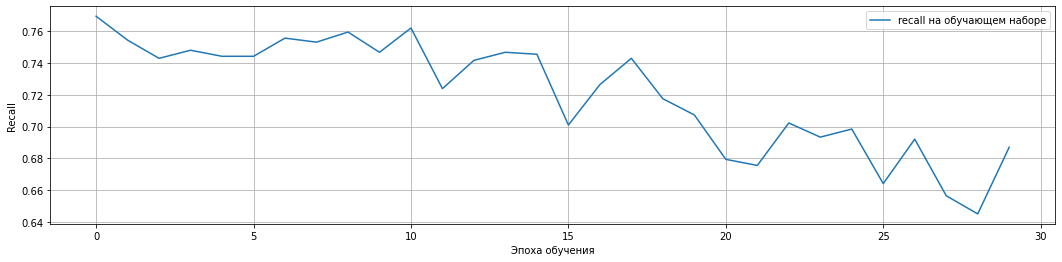

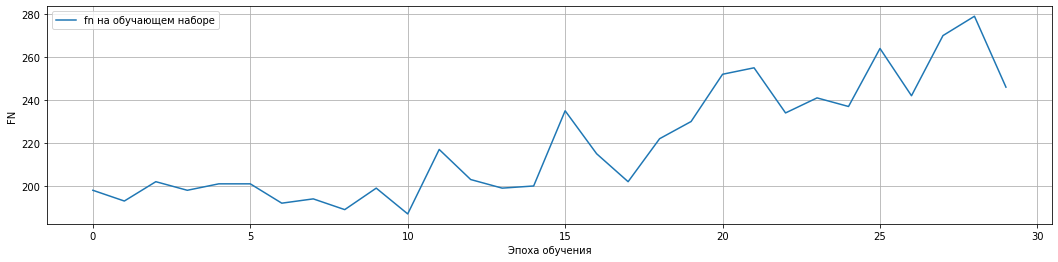

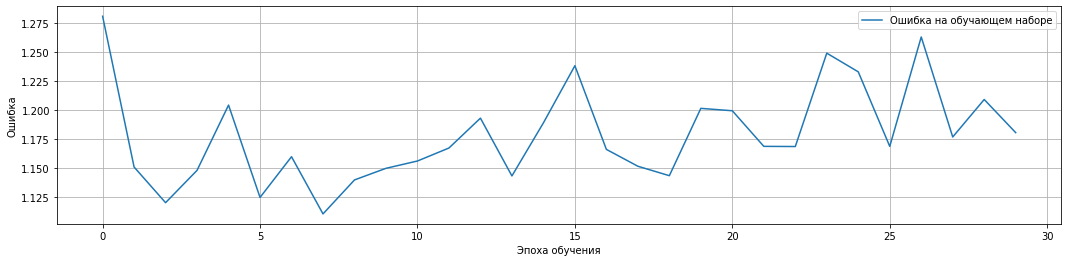

In [ ]:
pltFigureRecall(history2)
pltFigureFN(history2)
pltFigureLoss(history2)

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsLoss.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 2s 56ms/step - loss: 1.0444 - accuracy: 0.9375 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 149.0000 - tn: 258.0000 - precision: 0.2837


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 31ms/step - loss: 1.0444 - accuracy: 0.9375 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 149.0000 - tn: 258.0000 - precision: 0.2837
pred.shape  (96, 5)
по столбцу  0  совпало  65  что составляет  67.71  %
по столбцу  1  совпало  62  что составляет  64.58  %
по столбцу  2  совпало  64  что составляет  66.67  %
по столбцу  3  совпало  65  что составляет  67.71  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   66.042  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный отв

In [ ]:
model.compile(optimizer=Adam(0.0005), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])

history2 = model.fit(xAll, yAll,
                    epochs=80, 
                    verbose=1,
                    batch_size = 32,
                    # validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint, model_checkpoint_recall],
                    initial_epoch = 50)

Epoch 51/80
30/30 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.9319 - fn: 200.0000 - tp: 659.0000 - recall: 0.7672 - fp: 1638.0000 - tn: 2758.0000 - precision: 0.2869
Epoch 51: loss did not improve from 1.11029

Epoch 51: recall did not improve from 0.77735
30/30 [==============================] - 10s 133ms/step - loss: 1.1280 - accuracy: 0.9319 - fn: 200.0000 - tp: 659.0000 - recall: 0.7672 - fp: 1638.0000 - tn: 2758.0000 - precision: 0.2869
Epoch 52/80
30/30 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.9330 - fn: 197.0000 - tp: 589.0000 - recall: 0.7494 - fp: 1479.0000 - tn: 2510.0000 - precision: 0.2848
Epoch 52: loss did not improve from 1.11029

Epoch 52: recall did not improve from 0.77735
30/30 [==============================] - 4s 131ms/step - loss: 1.1259 - accuracy: 0.9330 - fn: 197.0000 - tp: 589.0000 - recall: 0.7494 - fp: 1479.0000 - tn: 2510.0000 - precision: 0.2848
Epoch 53/80
30/30 [==============================] - 

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsLoss.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 1s 34ms/step - loss: 0.9559 - accuracy: 0.9375 - fn: 17.0000 - tp: 56.0000 - recall: 0.7671 - fp: 143.0000 - tn: 264.0000 - precision: 0.2814


In [ ]:
score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 80ms/step - loss: 0.9559 - accuracy: 0.9375 - fn: 17.0000 - tp: 56.0000 - recall: 0.7671 - fp: 143.0000 - tn: 264.0000 - precision: 0.2814


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 34ms/step - loss: 0.9559 - accuracy: 0.9375 - fn: 17.0000 - tp: 56.0000 - recall: 0.7671 - fp: 143.0000 - tn: 264.0000 - precision: 0.2814
pred.shape  (96, 5)
по столбцу  0  совпало  66  что составляет  68.75  %
по столбцу  1  совпало  62  что составляет  64.58  %
по столбцу  2  совпало  65  что составляет  67.71  %
по столбцу  3  совпало  65  что составляет  67.71  %
по столбцу  4  совпало  62  что составляет  64.58  %
Итоговый процент   66.66599999999998  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  -->

In [ ]:
df_sample = compilingSample(model)
df_sample

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 28ms/step - loss: 0.9559 - accuracy: 0.9375 - fn: 17.0000 - tp: 56.0000 - recall: 0.7671 - fp: 143.0000 - tn: 264.0000 - precision: 0.2814

XTest.shape  (638, 9)
predict готов --> pred.shape  (638, 5)
[[1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]] 



,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,1,0,0,0,0
1,54-002-133-01,1,1,1,1,1
2,54-001-007-01,1,1,1,1,1
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,1,1,1,1,1
...,...,...,...,...,...,...
633,54-102-095-01,1,1,1,1,1
634,54-102-235-01,1,1,1,1,1
635,54-502-016-01,1,0,0,0,0
636,54-002-138-01,0,0,0,0,0


In [ ]:
df_sample.to_csv('/content/drive/My Drive/Ярославль/sampleAll_loss.csv', encoding='utf8', index=False)
model.save_weights('/content/drive/My Drive/Ярославль/weights_modelAll_loss.h5')

**> Score = 0.686779**

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsRecall.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 36ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 28ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950
pred.shape  (96, 5)
по столбцу  0  совпало  65  что составляет  67.71  %
по столбцу  1  совпало  64  что составляет  66.67  %
по столбцу  2  совпало  67  что составляет  69.79  %
по столбцу  3  совпало  68  что составляет  70.83  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   67.708  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 0. 0. 0. 1.]  --> верный отв

In [ ]:
df_sample = compilingSample(model)
df_sample

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 30ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950

XTest.shape  (638, 9)
predict готов --> pred.shape  (638, 5)
[[1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]] 



,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,1,0,0,0,0
1,54-002-133-01,1,1,1,1,1
2,54-001-007-01,1,1,1,1,1
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,1,1,1,1,1
...,...,...,...,...,...,...
633,54-102-095-01,1,1,1,1,1
634,54-102-235-01,1,1,1,1,1
635,54-502-016-01,1,0,0,0,0
636,54-002-138-01,0,0,0,0,0


In [ ]:
df_sample.to_csv('/content/drive/My Drive/Ярославль/sampleAll_recall80.csv', encoding='utf8', index=False)
model.save_weights('/content/drive/My Drive/Ярославль/weights_modelAll_recall80.h5')

y_test.shape --> (96, 5)
pred.shape --> (96, 5)


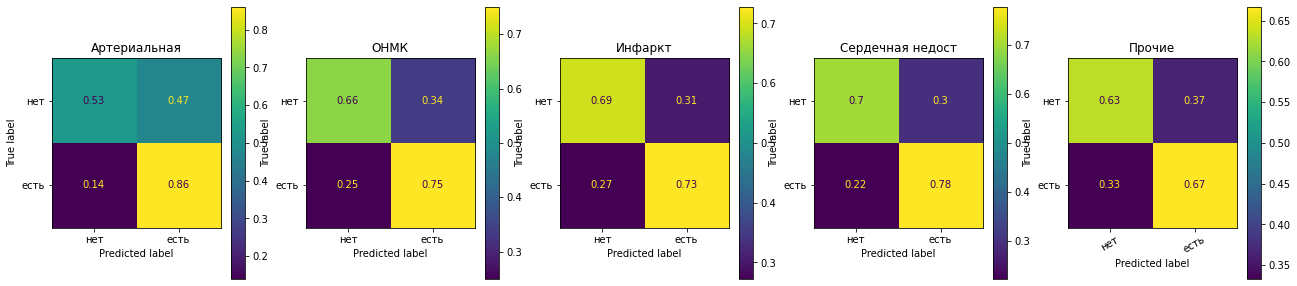

In [ ]:
confusionMatrix(model)

# Из Модуля  > Score = 0.699778

In [ ]:
import Service
import MODEL

In [ ]:

model1 = MODEL.create_Conv1_D()
model1.load_weights('/content/drive/My Drive/Ярославль/weights_modelAll_recall80.h5') ## > Score = 0.699778

score = model1.evaluate(x_test, y_test)

3/3 [==============================] - 2s 31ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 28.0000 - tp: 118.0000 - recall: 0.8082 - fp: 282.0000 - tn: 532.0000 - precision: 0.2950


In [ ]:
score = model1.evaluate(x_test, y_test)

3/3 [==============================] - 0s 45ms/step - loss: 1.1431 - accuracy: 0.8542 - fn: 14.0000 - tp: 59.0000 - recall: 0.8082 - fp: 141.0000 - tn: 266.0000 - precision: 0.2950


In [ ]:
predict = Service.predictSampling(model1, XTest)

Sampling.shape  (638, 9)


In [ ]:
print("Получаем размерность ", predict.shape)
predict

Получаем размерность  (638, 5)


array([[1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Conv1d - 4блока + concatenate: (по recall 84.9) > Score = 0.696836
#                                (по loss ) > Score = 0.6945
# урезан: 9 столбцов, + class_weights 

class_weights = {class_id : maxlen/num for class_id, num in enumerate(classes)} 

{0: 2.1412556053811658,
 1: 23.29268292682927,
 2: 8.162393162393162,
 3: 9.947916666666666,
 4: 11.104651162790697}




In [ ]:
class_weights = {0: 2.1412556053811658,
 1: 23.29268292682927,
 2: 8.162393162393162,
 3: 9.947916666666666,
 4: 11.104651162790697}

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

patch = '/content/drive/My Drive/Ярославль/'
model_checkpoint = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsLoss.h5'), 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

model_checkpoint_recall = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsRecall.h5'), 
                                   monitor='val_recall', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='max')   # mode='auto'

# patchMod = '/content/drive/My Drive/Ярославль/model_weightsUnet.h5'
# callbacks=[model_checkpoint]

gc.collect()

75347

In [ ]:
print(x_train.shape)
print(y_train.shape)


(773, 9)
(773, 5)


In [ ]:
# Функция по созданию сети UNET

def create_Conv1_D(numN=32, k = 1, num_classes = 5, input_shape= (9,), drop = 0.4):
    x_input = Input(input_shape) 
    # x = Reshape((32, 1))(x_input)
    
    x = Dense(numN)(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop)(x)

    x = Dense(numN*2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((numN*2, 1))(x)

    # Блок 1
    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    x = Activation('relu')(x)

    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    x = Activation('relu')(x)

    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)  
    block_1_out = Activation('relu')(x) 

    # Блок 2
    # x = MaxPooling1D()(block_1_out)
    x = AveragePooling1D()(block_1_out)

    x = Conv1D(numN * 2 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(numN * 2 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    # x = MaxPooling1D()(block_2_out)
    x = AveragePooling1D()(block_2_out)

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)                     

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x = Dropout(drop)(x)

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    # x = MaxPooling1D()(block_3_out)
    x = AveragePooling1D()(block_3_out)

    x = Conv1D(numN * 8 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    
    x = Conv1D(numN * 8  * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    
    
    f1 = Flatten()(block_1_out)
    f2 = Flatten()(block_2_out)
    f3 = Flatten()(block_3_out)
    f4 = Flatten()(block_4_out)

    x = concatenate([f1, f2, f3, f4])
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(x_input, out) 
    model.compile(optimizer=Adam(0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])
  
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 32)           320         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 32)          128         ['dense_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 32)           0           ['batch_normalization_26[0]

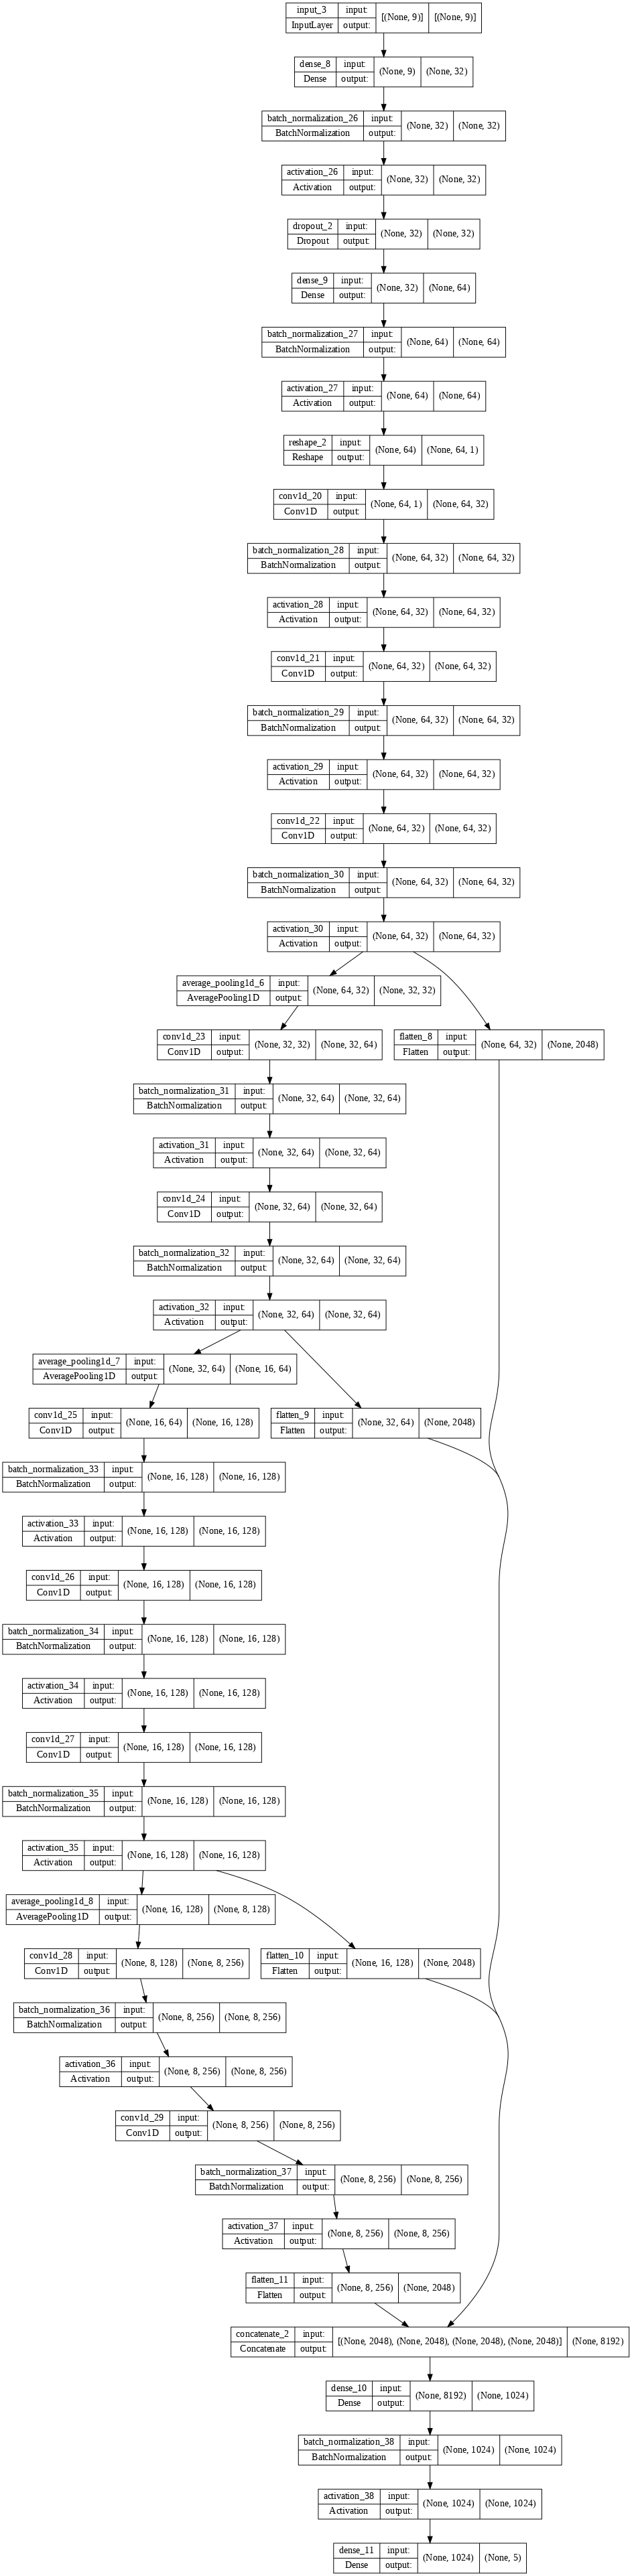

In [ ]:
model = create_Conv1_D()
model.summary()
print()
plot_model(model, dpi=70, show_shapes=True )

In [ ]:
history2 = model.fit(x_train, y_train,
                    epochs=50, 
                    verbose=1,
                    batch_size = 32,
                    validation_data=(x_val, y_val),
                    class_weight=class_weight,
                    callbacks=[model_checkpoint, model_checkpoint_recall])

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.3254 - accuracy: 0.5640 - fn: 299.0000 - tp: 356.0000 - recall: 0.5435 - fp: 960.0000 - tn: 2250.0000 - precision: 0.2705
Epoch 1: val_loss improved from inf to 1.00187, saving model to /content/drive/My Drive/Ярославль/model_weightsLoss.h5

Epoch 1: val_recall improved from -inf to 0.00000, saving model to /content/drive/My Drive/Ярославль/model_weightsRecall.h5
25/25 [==============================] - 13s 252ms/step - loss: 2.3254 - accuracy: 0.5640 - fn: 299.0000 - tp: 356.0000 - recall: 0.5435 - fp: 960.0000 - tn: 2250.0000 - precision: 0.2705 - val_loss: 1.0019 - val_accuracy: 0.4767 - val_fn: 58.0000 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 372.0000 - val_precision: 0.0000e+00
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.6075 - accuracy: 0.5834 - fn: 265.0000 - tp: 390.0000 - recall: 0.5954 - fp: 1066.0000 - tn: 2144.0000 - precision: 0.2679
Epoch 2: 

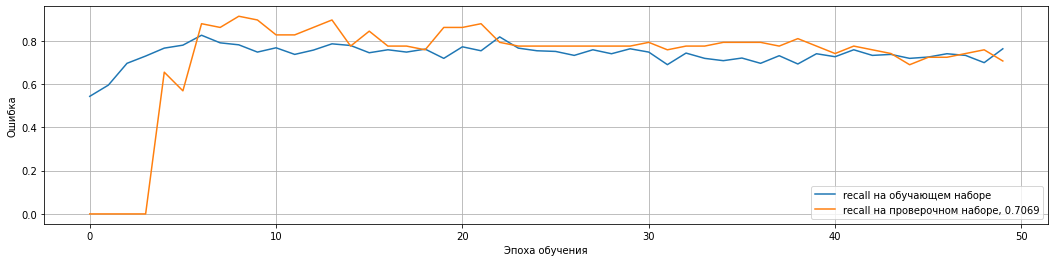

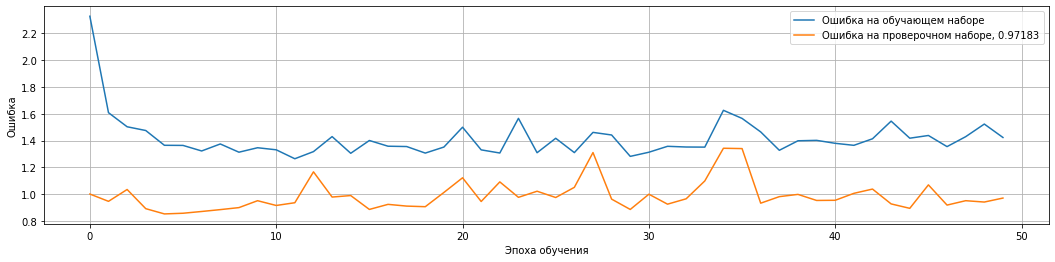

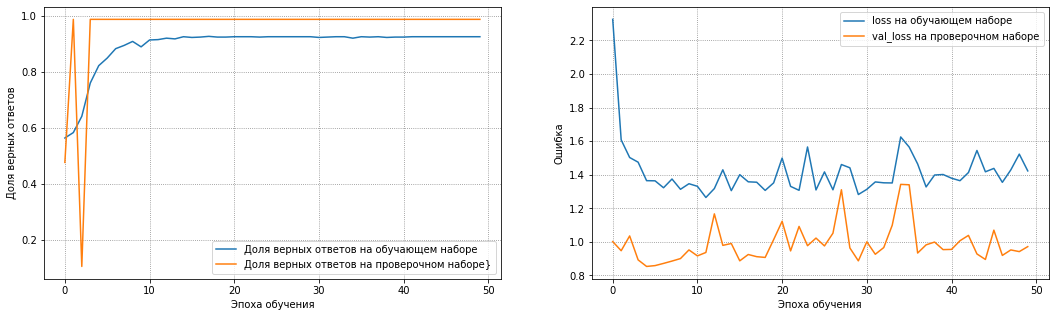

In [ ]:
pltFigureRecall(history2)
pltFigureLoss(history2)
PlotFunctions.plt_figure_accuracy(history2)

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsLoss.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 4s 80ms/step - loss: 0.9602 - accuracy: 0.9375 - fn: 18.0000 - tp: 55.0000 - recall: 0.7534 - fp: 122.0000 - tn: 285.0000 - precision: 0.3107


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 32ms/step - loss: 0.9602 - accuracy: 0.9375 - fn: 18.0000 - tp: 55.0000 - recall: 0.7534 - fp: 122.0000 - tn: 285.0000 - precision: 0.3107
pred.shape  (96, 5)
по столбцу  0  совпало  70  что составляет  72.92  %
по столбцу  1  совпало  75  что составляет  78.12  %
по столбцу  2  совпало  65  что составляет  67.71  %
по столбцу  3  совпало  69  что составляет  71.88  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   70.834  % 

Пример:  0  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 1. 0. 1.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 0. 1. 0. 1.]  --> верный отв

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsRecall.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 35ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 217.0000 - tn: 190.0000 - precision: 0.2222


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 33ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 217.0000 - tn: 190.0000 - precision: 0.2222
pred.shape  (96, 5)
по столбцу  0  совпало  66  что составляет  68.75  %
по столбцу  1  совпало  47  что составляет  48.96  %
по столбцу  2  совпало  45  что составляет  46.88  %
по столбцу  3  совпало  52  что составляет  54.17  %
по столбцу  4  совпало  42  что составляет  43.75  %
Итоговый процент   52.501999999999995  % 

Пример:  0  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  --

In [ ]:
# model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d.h5')

model.compile(optimizer=Adam(0.0008), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])

history2 = model.fit(x_train, y_train,
                    epochs=80, 
                    verbose=1,
                    batch_size = 32,
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint, model_checkpoint_recall],
                    initial_epoch = 50)

Epoch 51/80
25/25 [==============================] - ETA: 0s - loss: 1.2319 - accuracy: 0.9030 - fn: 187.0000 - tp: 541.0000 - recall: 0.7431 - fp: 1543.0000 - tn: 2074.0000 - precision: 0.2596
Epoch 51: val_loss did not improve from 0.85381

Epoch 51: val_recall did not improve from 0.91379
25/25 [==============================] - 11s 228ms/step - loss: 1.2319 - accuracy: 0.9030 - fn: 187.0000 - tp: 541.0000 - recall: 0.7431 - fp: 1543.0000 - tn: 2074.0000 - precision: 0.2596 - val_loss: 0.8940 - val_accuracy: 0.9884 - val_fn: 7.0000 - val_tp: 51.0000 - val_recall: 0.8793 - val_fp: 170.0000 - val_tn: 202.0000 - val_precision: 0.2308
Epoch 52/80
25/25 [==============================] - ETA: 0s - loss: 1.1843 - accuracy: 0.9224 - fn: 161.0000 - tp: 494.0000 - recall: 0.7542 - fp: 1339.0000 - tn: 1871.0000 - precision: 0.2695
Epoch 52: val_loss did not improve from 0.85381

Epoch 52: val_recall did not improve from 0.91379
25/25 [==============================] - 4s 158ms/step - loss: 1.

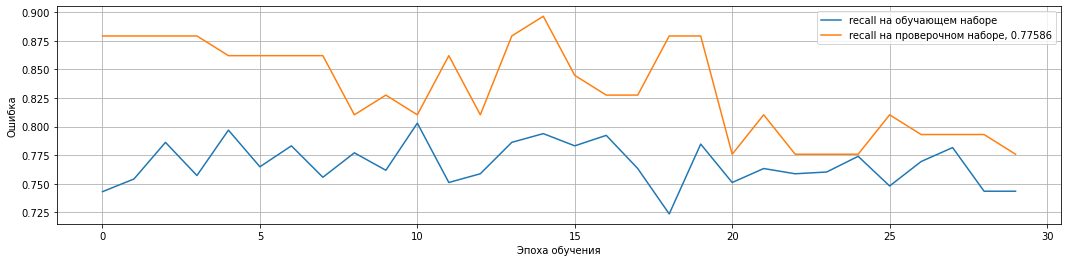

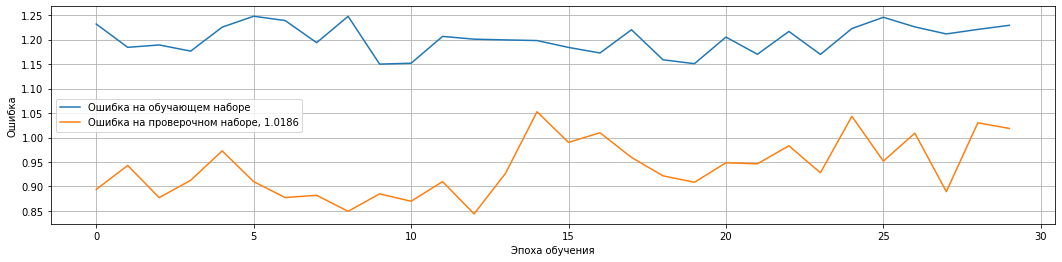

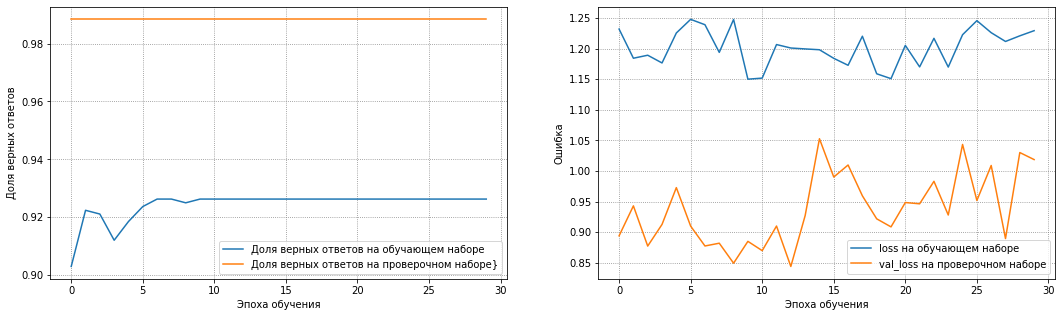

In [ ]:
pltFigureRecall(history2)
pltFigureLoss(history2)
PlotFunctions.plt_figure_accuracy(history2)

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsLoss.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 1s 34ms/step - loss: 1.0040 - accuracy: 0.9375 - fn: 15.0000 - tp: 58.0000 - recall: 0.7945 - fp: 163.0000 - tn: 244.0000 - precision: 0.2624


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 33ms/step - loss: 1.0040 - accuracy: 0.9375 - fn: 15.0000 - tp: 58.0000 - recall: 0.7945 - fp: 163.0000 - tn: 244.0000 - precision: 0.2624
pred.shape  (96, 5)
по столбцу  0  совпало  65  что составляет  67.71  %
по столбцу  1  совпало  60  что составляет  62.5  %
по столбцу  2  совпало  60  что составляет  62.5  %
по столбцу  3  совпало  59  что составляет  61.46  %
по столбцу  4  совпало  58  что составляет  60.42  %
Итоговый процент   62.91799999999999  % 

Пример:  0  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 0. 0. 0. 0.]  --> в

In [ ]:
df_sample = compilingSample(model)
df_sample

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 35ms/step - loss: 1.0040 - accuracy: 0.9375 - fn: 15.0000 - tp: 58.0000 - recall: 0.7945 - fp: 163.0000 - tn: 244.0000 - precision: 0.2624

XTest.shape  (638, 9)
predict готов --> pred.shape  (638, 5)
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]] 



,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,1,1,1,1,1
1,54-002-133-01,1,1,1,1,1
2,54-001-007-01,1,0,0,0,0
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,1,1,1,1,1
...,...,...,...,...,...,...
633,54-102-095-01,1,1,1,1,1
634,54-102-235-01,1,1,1,1,1
635,54-502-016-01,1,1,1,1,1
636,54-002-138-01,0,0,0,0,0


In [ ]:
df_sample.to_csv('/content/drive/My Drive/Ярославль/sampleConv_9z_weigs2_loss1.csv', encoding='utf8', index=False)
model.save_weights('/content/drive/My Drive/Ярославль/weights_modelConv_9z_weigs2_loss1.h5')

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsRecall.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 35ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 217.0000 - tn: 190.0000 - precision: 0.2222


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 41ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 217.0000 - tn: 190.0000 - precision: 0.2222
pred.shape  (96, 5)
по столбцу  0  совпало  66  что составляет  68.75  %
по столбцу  1  совпало  47  что составляет  48.96  %
по столбцу  2  совпало  45  что составляет  46.88  %
по столбцу  3  совпало  52  что составляет  54.17  %
по столбцу  4  совпало  42  что составляет  43.75  %
Итоговый процент   52.501999999999995  % 

Пример:  0  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  --

In [ ]:
df_sample = compilingSample(model)
df_sample

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 34ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 217.0000 - tn: 190.0000 - precision: 0.2222

XTest.shape  (638, 9)
predict готов --> pred.shape  (638, 5)
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]] 



,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,1,1,1,1,1
1,54-002-133-01,1,1,1,1,1
2,54-001-007-01,1,1,1,1,1
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,1,1,1,1,1
...,...,...,...,...,...,...
633,54-102-095-01,0,0,0,0,0
634,54-102-235-01,1,1,1,1,1
635,54-502-016-01,1,1,1,1,1
636,54-002-138-01,0,0,0,0,0


In [ ]:
df_sample.to_csv('/content/drive/My Drive/Ярославль/sampleConv_9z_weigs2_recall84.csv', encoding='utf8', index=False)
model.save_weights('/content/drive/My Drive/Ярославль/weights_modelConv_9z_weigs2_recall84.h5')

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/weights_modelConv_9z_weigs2_recall84.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 4s 97ms/step - loss: 1.0078 - accuracy: 0.9375 - fn: 25.0000 - tp: 121.0000 - recall: 0.8288 - fp: 358.0000 - tn: 456.0000 - precision: 0.2526


y_test.shape --> (96, 5)
pred.shape --> (96, 5)


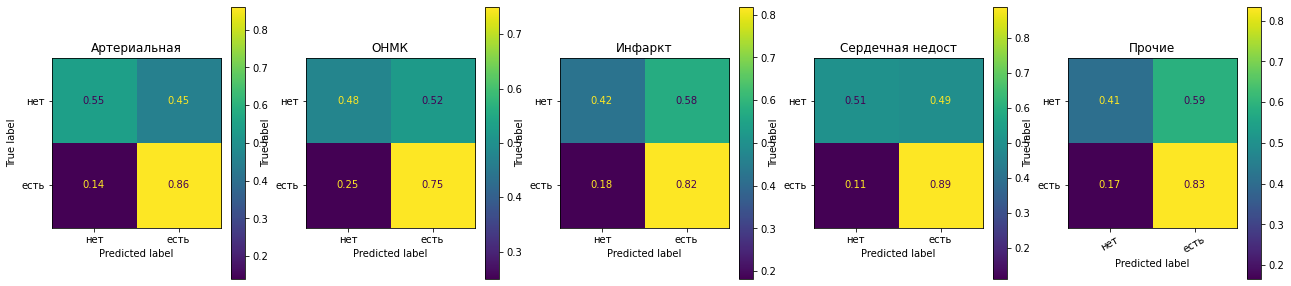

In [ ]:
confusionMatrix(model)

# Conv1d - 4блока + concatenate: (recall 84) > Score = 0.691502 
# урезан: 9 столбцов (monitor='val_recall')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

patch = '/content/drive/My Drive/Ярославль/'
model_checkpoint = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsConv1d.h5'), 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

model_checkpoint_recall = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsConv1d_recall.h5'), 
                                   monitor='val_recall', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='max')   # mode='auto'
                                   
# patchMod = '/content/drive/My Drive/Ярославль/model_weightsUnet.h5'
# callbacks=[model_checkpoint]

In [ ]:
print(x_train.shape)
print(y_train.shape)


(773, 9)
(773, 5)


In [ ]:
# Функция по созданию сети UNET
def create_Conv1d(numN = 32, k = 1, num_classes = 5, input_shape= (9,), drop = 0.4):
    x_input = Input(input_shape) 
    # x = Reshape((32, 1))(x_input)
    
    x = Dense(numN)(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((numN, 1))(x)


    # Блок 1
    x = Conv1D(numN * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)

    x = Conv1D(numN * 2 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    # x = Dropout(drop)(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)

    x = Conv1D(numN * 4 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)

    x = Conv1D(numN * 8  * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    
    
    f1 = Flatten()(block_1_out)
    f2 = Flatten()(block_2_out)
    f3 = Flatten()(block_3_out)
    f4 = Flatten()(block_4_out)

    x = concatenate([f1, f2, f3, f4])
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(y_train.shape[-1], activation='sigmoid')(x)
    
    model = Model(x_input, out) 
    model.compile(optimizer=Adam(0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])
  
    return model

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 dense_47 (Dense)               (None, 9)            90          ['input_19[0][0]']               
                                                                                                  
 batch_normalization_164 (Batch  (None, 9)           36          ['dense_47[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation_163 (Activation)    (None, 9)            0           ['batch_normalization_164[

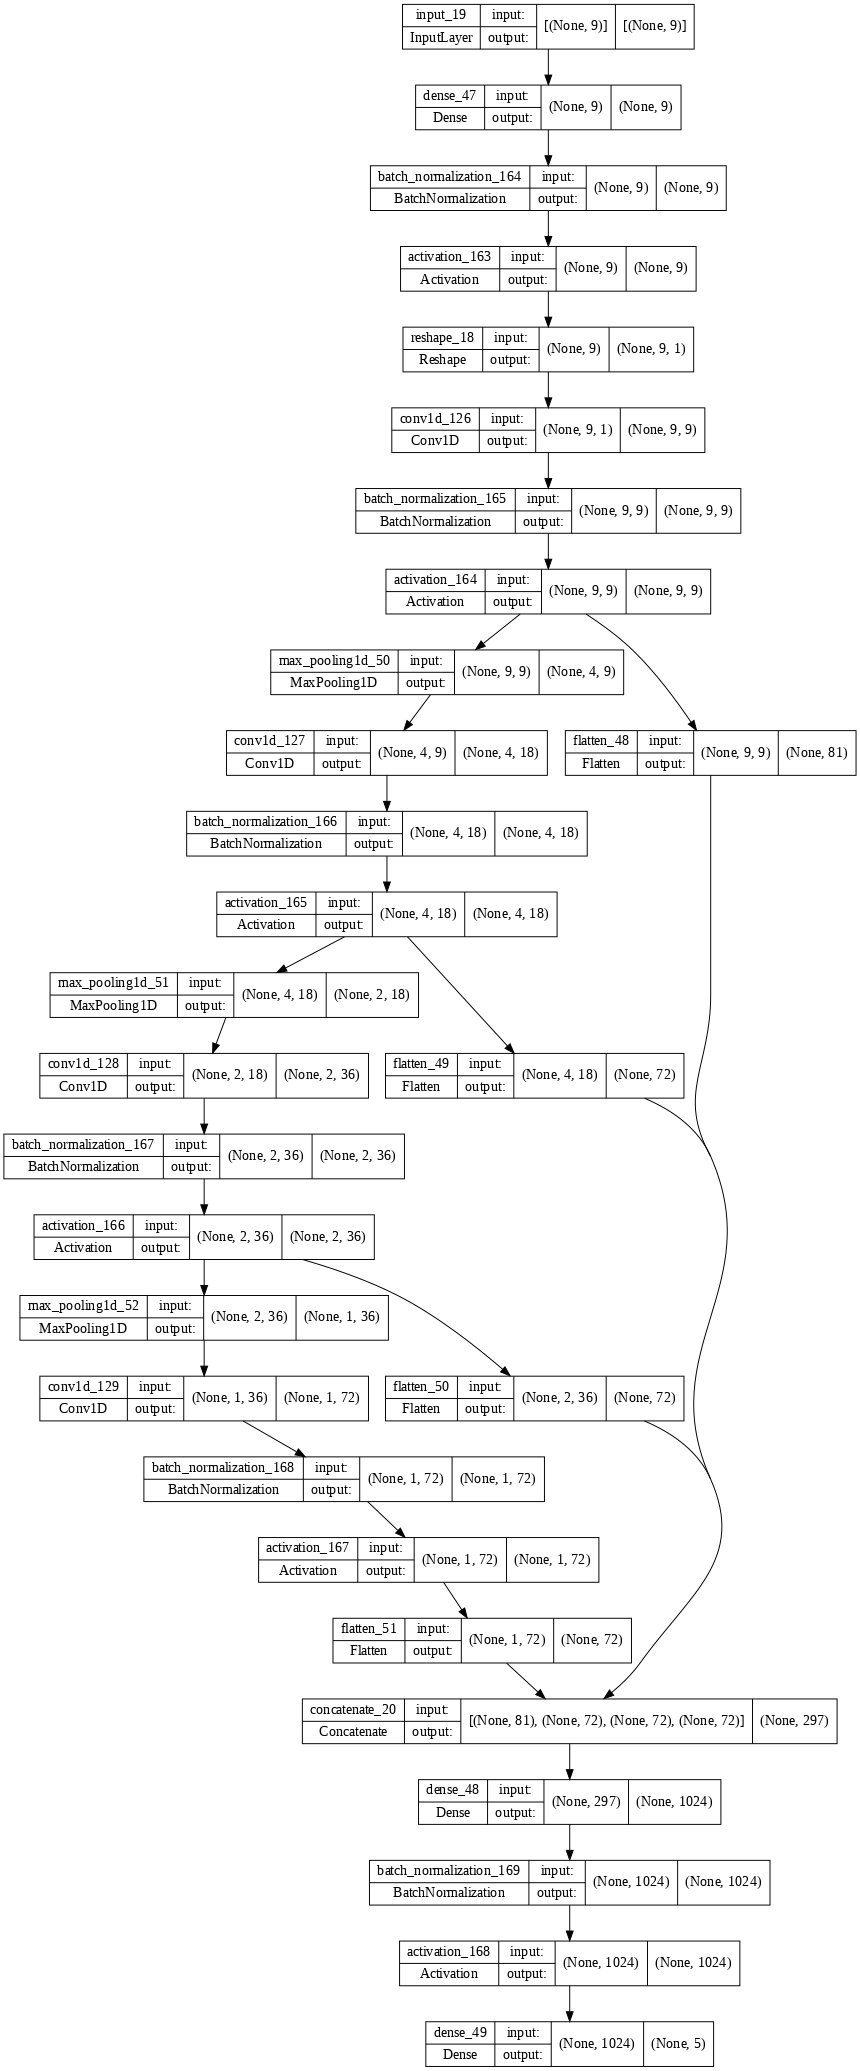

In [ ]:
model = create_Conv1d(x_train.shape[1])
model.summary()
print()
plot_model(model, dpi=70, show_shapes=True )

In [ ]:
history2 = model.fit(x_train, y_train,
                    epochs=50, 
                    verbose=1,
                    batch_size = 32,
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint, model_checkpoint_recall])

Epoch 1/50
24/25 [===========================>..] - ETA: 0s - loss: 1.4304 - accuracy: 0.6784 - fn: 250.0000 - tp: 401.0000 - recall: 0.6160 - fp: 880.0000 - tn: 2309.0000 - precision: 0.3130
Epoch 1: val_loss improved from inf to 1.03267, saving model to /content/drive/My Drive/Ярославль/model_weightsConv1d.h5

Epoch 1: val_recall improved from -inf to 0.10345, saving model to /content/drive/My Drive/Ярославль/model_weightsConv1d_recall.h5
25/25 [==============================] - 10s 131ms/step - loss: 1.4300 - accuracy: 0.6792 - fn: 250.0000 - tp: 405.0000 - recall: 0.6183 - fp: 886.0000 - tn: 2324.0000 - precision: 0.3137 - val_loss: 1.0327 - val_accuracy: 0.9884 - val_fn: 52.0000 - val_tp: 6.0000 - val_recall: 0.1034 - val_fp: 26.0000 - val_tn: 346.0000 - val_precision: 0.1875
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2821 - accuracy: 0.7891 - fn: 172.0000 - tp: 483.0000 - recall: 0.7374 - fp: 1334.0000 - tn: 1876.0000 - precision: 0.2658
Epoch 2: val_lo

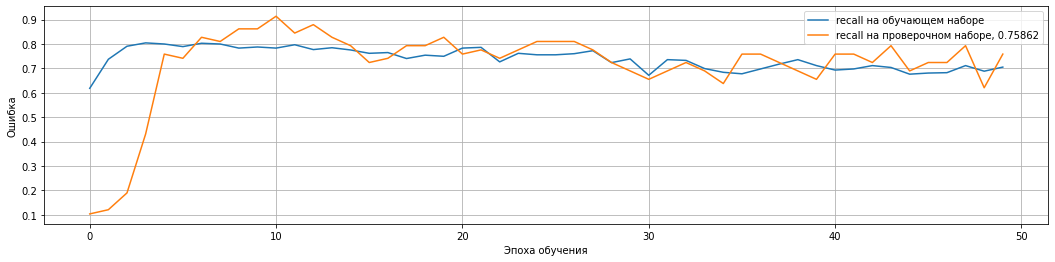

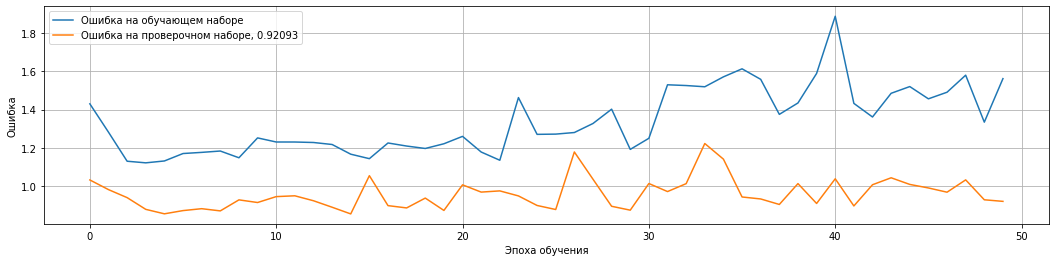

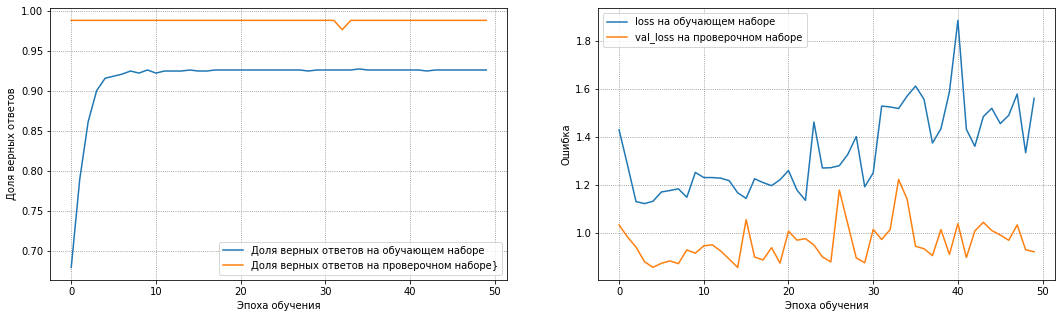

In [ ]:
pltFigureRecall(history2)
pltFigureLoss(history2)
PlotFunctions.plt_figure_accuracy(history2)

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 1s 9ms/step - loss: 0.9719 - accuracy: 0.9375 - fn: 20.0000 - tp: 53.0000 - recall: 0.7260 - fp: 138.0000 - tn: 269.0000 - precision: 0.2775


In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d_recall.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 13ms/step - loss: 1.0599 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 205.0000 - tn: 202.0000 - precision: 0.2322


In [ ]:
# model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d.h5')

model.compile(optimizer=Adam(0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', metrics])

history2 = model.fit(x_train, y_train,
                    epochs=100, 
                    verbose=1,
                    batch_size = 32,
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint, model_checkpoint_recall],
                    initial_epoch = 50)

Epoch 51/100
23/25 [==========================>...] - ETA: 0s - loss: 1.2007 - accuracy: 0.9239 - fn: 129.0000 - tp: 490.0000 - recall: 0.7916 - fp: 1223.0000 - tn: 1838.0000 - precision: 0.2860
Epoch 51: val_recall improved from -inf to 0.86207, saving model to /content/drive/My Drive/Ярославль/model_weights.h5

Epoch 51: val_recall did not improve from 0.91379
25/25 [==============================] - 9s 97ms/step - loss: 1.2169 - accuracy: 0.9250 - fn: 137.0000 - tp: 518.0000 - recall: 0.7908 - fp: 1291.0000 - tn: 1919.0000 - precision: 0.2863 - val_loss: 0.9253 - val_accuracy: 0.9884 - val_fn: 8.0000 - val_tp: 50.0000 - val_recall: 0.8621 - val_fp: 183.0000 - val_tn: 189.0000 - val_precision: 0.2146
Epoch 52/100
24/25 [===========================>..] - ETA: 0s - loss: 1.2124 - accuracy: 0.9245 - fn: 140.0000 - tp: 512.0000 - recall: 0.7853 - fp: 1270.0000 - tn: 1918.0000 - precision: 0.2873
Epoch 52: val_recall did not improve from 0.86207

Epoch 52: val_recall did not improve from 

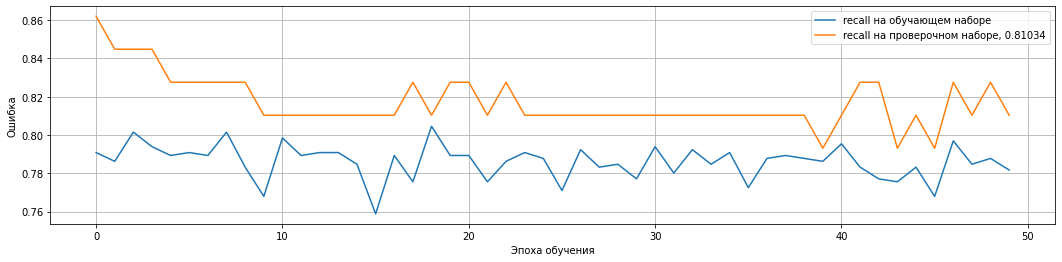

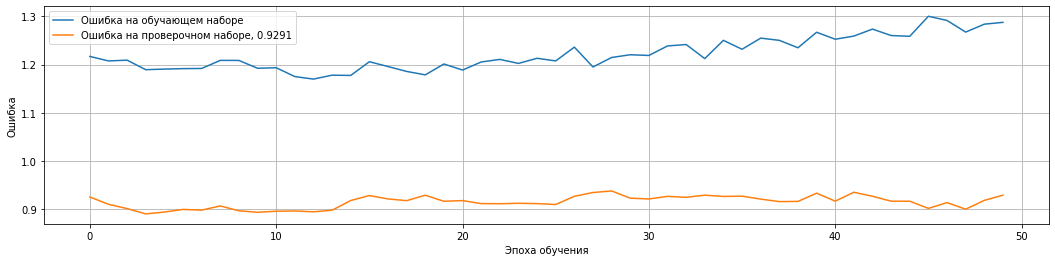

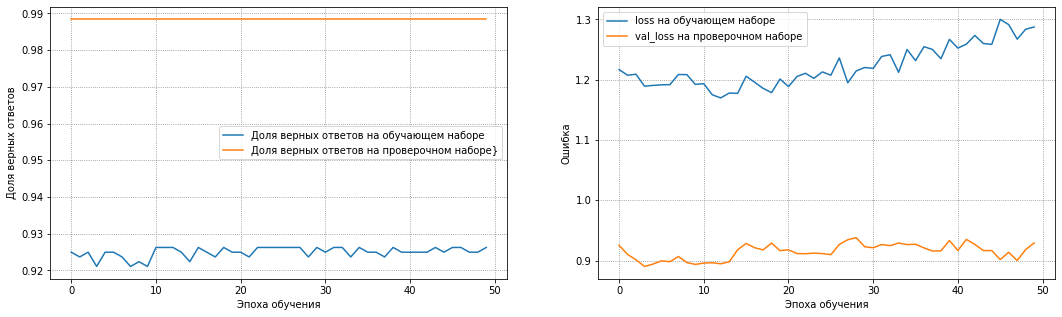

In [ ]:
pltFigureRecall(history2)
pltFigureLoss(history2)
PlotFunctions.plt_figure_accuracy(history2)

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d.h5')

score = model.evaluate(x_test, y_test)

3/3 [==============================] - 1s 8ms/step - loss: 0.9719 - accuracy: 0.9375 - fn: 20.0000 - tp: 53.0000 - recall: 0.7260 - fp: 138.0000 - tn: 269.0000 - precision: 0.2775


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 10ms/step - loss: 0.9719 - accuracy: 0.9375 - fn: 20.0000 - tp: 53.0000 - recall: 0.7260 - fp: 138.0000 - tn: 269.0000 - precision: 0.2775
pred.shape  (96, 5)
по столбцу  0  совпало  68  что составляет  70.83  %
по столбцу  1  совпало  63  что составляет  65.62  %
по столбцу  2  совпало  64  что составляет  66.67  %
по столбцу  3  совпало  66  что составляет  68.75  %
по столбцу  4  совпало  61  что составляет  63.54  %
Итоговый процент   67.08200000000001  % 

Пример:  0  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 0. 0. 0. 0.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  -->

In [ ]:
model.load_weights('/content/drive/My Drive/Ярославль/model_weightsConv1d_recall.h5')
score = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 1.0382 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 199.0000 - tn: 208.0000 - precision: 0.2375


In [ ]:
evalModel(model)

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 7ms/step - loss: 1.0382 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 199.0000 - tn: 208.0000 - precision: 0.2375
pred.shape  (96, 5)
по столбцу  0  совпало  70  что составляет  72.92  %
по столбцу  1  совпало  50  что составляет  52.08  %
по столбцу  2  совпало  51  что составляет  53.12  %
по столбцу  3  совпало  51  что составляет  53.12  %
по столбцу  4  совпало  48  что составляет  50.0  %
Итоговый процент   56.248000000000005  % 

Пример:  0  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [0 0 0 0 0]
Пример:  1  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 1 0 0]
Пример:  2  Сеть определила:  [0. 0. 0. 0. 0.]  --> верный ответ:  [0 0 0 0 0]
Пример:  3  Сеть определила:  [1. 0. 1. 1. 1.]  --> верный ответ:  [0 0 0 0 0]
Пример:  4  Сеть определила:  [1. 1. 1. 1. 1.]  --> верный ответ:  [1 0 0 0 0]
Пример:  5  Сеть определила:  [1. 1. 1. 1. 1.]  --> 

In [ ]:
df_sample = compilingSample(model)
df_sample

x_test.shape  (96, 9)
y_test.shape  (96, 5) 

3/3 [==============================] - 0s 10ms/step - loss: 1.0382 - accuracy: 0.9375 - fn: 11.0000 - tp: 62.0000 - recall: 0.8493 - fp: 199.0000 - tn: 208.0000 - precision: 0.2375

XTest.shape  (638, 9)
predict готов --> pred.shape  (638, 5)
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]] 



,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,1,1,1,1,1
1,54-002-133-01,1,1,1,1,1
2,54-001-007-01,1,1,1,1,1
3,54-102-116-01,0,0,0,0,0
4,54-502-005-02,1,1,1,1,1
...,...,...,...,...,...,...
633,54-102-095-01,1,1,1,1,1
634,54-102-235-01,1,1,1,1,1
635,54-502-016-01,1,1,1,1,1
636,54-002-138-01,0,0,0,0,0


In [ ]:
df_sample.to_csv('/content/drive/My Drive/Ярославль/sampleConv_9z_recall84.csv', encoding='utf8', index=False)

In [ ]:
model.save_weights('/content/drive/My Drive/Ярославль/weights_modelConv_9z_recall84.h5')

> Score = 0.691502

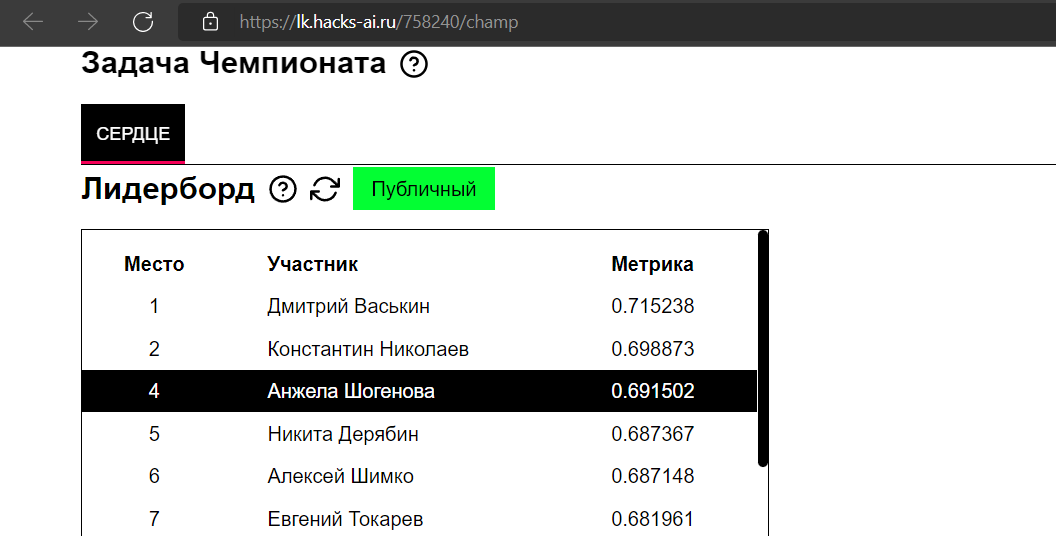